In [1]:
!pip install photutils
#NOTE!!! I had misunderstood the exact format by which we were supposed to align and combine our images. For some reason
# I got it into my head that we were supposed to align and combine every image within a given night with other images from that night
# that shared the same filter. I was not aware that we were in fact supposed to align and combine images within their own 6 image cycles.
# instead of within their respective nights. I will make this change into my aligning and combining pipeline at a later date.
# It shouldn't really change the structural process of extracting light curves, however, as the widget should still work properly after
# I have sorted the master science images into their own single folder. It will only change the light curves by making them more numerous
# (Since there will simply be several master science images per night instead of just one for every night)

In [2]:
# # The standard fare:
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
# from astropy.visualization import ZScaleInterval
# %matplotlib inline
# # Recall our use of this module to work with FITS files in Lab 4:
# from astropy.io import fits 


# # This lets us use various Unix (or Unix-like) commands within Python:
# import os 

# # We will see what this does shortly.
# import glob 
# import astropy.time

# import astropy.stats as stat
# from astropy.stats import mad_std
# from astropy.stats import sigma_clip
# from photutils.utils import calc_total_error

# from photutils import aperture_photometry, CircularAperture, CircularAnnulus, DAOStarFinder
import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.io import fits, ascii
from astropy.table import Table, Column
from astropy.visualization import ZScaleInterval
import astropy.time
import pandas as pd
import glob 
import scipy.signal
import scipy.ndimage.interpolation as interp
import shutil
import pdb
import photutils
import astropy.stats as stat
from astropy.stats import mad_std
from astropy.stats import sigma_clip
from photutils.utils import calc_total_error
import os
from pathlib import Path
from photutils import aperture_photometry, CircularAperture, CircularAnnulus, DAOStarFinder
from astropy import units as u
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u

In [3]:
#changing directory into where shift_methods is
os.chdir('C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/light curves')

In [4]:
import shift_methods as p
from importlib import reload
%reload_ext autoreload 
%autoreload 2 
reload(p)

<module 'shift_methods' from 'C:\\Users\\Batmanlai Tsogt\\Documents\\College Work\\Senior Year\\AST341\\Jupyter\\light curves\\shift_methods.py'>

In [5]:
def filesorter(filename, foldername, fitskeyword_to_check, keyword):
    '''
    Takes .fit files with a specific keyword value in their header and sends them to the specified
    folder-- if the folder does't exist, it creates it.
    
    Inputs:
    filename (str) - name of .fits file
    foldername (str) - name of folder that the .fits file may be sorted to
    fitskeyword_to_check (str) - if the value of the header category keyword matches this input, then the .fits file will 
                                    be sorted to foldername
    keyword (str) - the header category that is being checked
    '''
    # Checking to see if the filename exists, if it doesn't, it prints that the filename does not exist or that it has been moved.  
    if os.path.exists(filename):
        pass
    else:
        print(filename + " does not exist or has already been moved.")
        return
    #acquiring all 'column' headers for specified filename, assigning it to header
    #then assigning values under specified header keyword to fits_type
    header = fits.getheader(filename)
    fits_type = header[keyword]
    
    # Checking to see if foldername exists. If it does, move on, if it doesn't, it generates a folder of that name.
    if os.path.exists(foldername):
        pass
    else:
        print("Making new directory: " + foldername)
        os.mkdir(foldername)
    
    # Checks to see if the fits_type we got from the keyword header matches the fitskeyword we are looking for. If it does, it moves it into the destination which is specified by the
    # foldername we inputted into the function. If it does not, it just doesn't do anything. 
    if fits_type == fitskeyword_to_check:
        destination = foldername + '/'
        print("Moving " + filename + " to: ./" + destination + filename)
        os.rename(filename, destination + filename)  
    return
def filesorter_modified(filename, foldername, fitskeyword_to_check, keyword):
    '''
    Takes .fit files with a specific keyword value in their header and sends them to the specified
    folder-- if the folder does't exist, it creates it.
    
    Inputs:
    filename (str) - name of .fits file
    foldername (str) - name of folder that the .fits file may be sorted to
    fitskeyword_to_check (str) - if the value of the header category keyword matches this input, then the .fits file will 
                                    be sorted to foldername
    keyword (str) - the header category that is being checked
    '''
    # Checking to see if foldername exists. If it does, move on, if it doesn't, it generates a folder of that name.
    if os.path.exists(foldername):
        pass
    else:
        print("Making new directory: " + foldername)
        os.mkdir(foldername)
        
    # Checking to see if the filename exists, if it doesn't, it prints that the filename does not exist or that it has been moved.  
    if os.path.exists(filename):
        pass
    else:
        print(filename + " does not exist or has already been moved.")
        return
    #acquiring all 'column' headers for specified filename, assigning it to header
    #then assigning values under specified header keyword to fits_type
    header = fits.getheader(filename)
    fits_type = header[keyword]
    
    # Checks to see if the fits_type we got from the keyword header matches the fitskeyword we are looking for. If it does, it moves it into the destination which is specified by the
    # foldername we inputted into the function. If it does not, it just doesn't do anything. 
    if fits_type == fitskeyword_to_check:
        destination = foldername + '/'
        print("Moving " + filename + " to: ./" + destination + filename)
        os.rename(filename, destination + filename)  
    return

In [6]:
def sortall(master_directory):
    '''
    Loops through each directory in a given master directory for darks and flats, sorts them based on EXPTIME and FILTER.
    Inputs:
    master_directory (str) - the directory where all of the raw data folders are
    '''
    for root, dirs, files in os.walk(master_directory):
        for i in dirs:
            if 'Darks' in i:
                os.chdir(master_directory+"/"+i)
                dark_fits = glob.glob('*.fit')
                times = []
                for i in dark_fits:
                    headers = fits.getheader(i)
                    times.append(headers['EXPTIME'])
                times = np.array(times)
                uniquetimes = np.unique(times)
                for i in range(len(uniquetimes)):
                    for yeet in dark_fits:
                        filesorter(yeet, str(uniquetimes[i]) + 'sec', uniquetimes[i], 'EXPTIME')
            elif 'Flats' in i:
                os.chdir(master_directory+"/"+i)
                all_fits = glob.glob('*.fit')
                for filename in all_fits:
                    filesorter(filename, 'Blue', 'B', 'FILTER')
                    filesorter(filename, 'Visual', 'V', 'FILTER')
                    filesorter(filename, 'Red', 'R', 'FILTER')  
    return

In [7]:
master_dir = 'C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/light curves'
# sortall(master_dir)

In [153]:
def mediancombinenan(filelist):
    '''
    The function takes 1 input, a list of fits files to be combined, and takes the median
    pixel values for each pixel, outputting a median fits file. This function ignores naN values.
    
    Inputs:
    filelist (array-like) - a list of strings that are filepaths to images to be combined
    '''
    # Defines variable holding the length of the inputted list of files.
    n = len(filelist)
    
    # Assigns a name to the array data of the first file in the list.
    first_frame_data = fits.getdata(filelist[0])
    
        # Puts the y and x dimensions of the image into variables.
    imsize_y, imsize_x = first_frame_data.shape
    
    # Creates an empty three-dimensional array which will store the data from the entire list of files.
    fits_stack = np.zeros((imsize_y, imsize_x , n)) 
    
    # Goes through the list of files and sets the corresponding element in the array to the value of the
    # current pixel.
    for ii in range(0, n):
        im = fits.getdata(filelist[ii])
        hed = fits.getheader(filelist[ii])
        if (hed['EXPTIME']> 60):
            im_normal = im/hed['EXPTIME']
            im_final = im_normal*60
        else: im_final = im
        fits_stack[:,:,ii] = im_final
        
    # Uses a numpy function to create a median frame along the third axis, which it then returns.        
    med_frame = np.nanmedian(fits_stack, axis = 2)
    
    return med_frame

def mediancombinescience(filelist):
    '''
    The function takes 1 input, a list of fits files to be combined, and takes the median
    pixel values for each pixel, outputting a median fits file.
    
    Inputs:
    filelist (array-like) - a list of strings that are filepaths to images to be combined
    '''
    # Defines variable holding the length of the inputted list of files.
    n = len(filelist)
    
    # Assigns a name to the array data of the first file in the list.
    first_frame_data = fits.getdata(filelist[0])
    
    # Puts the y and x dimensions of the image into variables.
    imsize_y, imsize_x = first_frame_data.shape
    
    # Creates an empty three-dimensional array which will store the data from the entire list of files.
    fits_stack = np.zeros((imsize_y, imsize_x , n)) 
    
    # Goes through the list of files and sets the corresponding element in the array to the value of the
    # current pixel.
    for ii in range(0, n):
        im = fits.getdata(filelist[ii])
        fits_stack[:,:,ii] = im
        
    # Uses a numpy function to create a median frame along the third axis, which it then returns.        
    med_frame = np.nanmedian(fits_stack, axis = 2)
    
    return med_frame

def bias_subtract(filename, path_to_bias):
    '''
    This function takes two inputs: name of a file and a file path to the master bias and subtracts the master bias from the data
    It creates a file with the prefix 'b_', the new data, the header, and overwrites any existing files with the same name
    
    Inputs:
    filename (str) - filepath to image that is to be bias subtracted
    path_to_bias (str) - filepath to master bias image
    '''
    #grab information from input filepaths
    data = fits.getdata(filename)
    header = fits.getheader(filename)
    mb = fits.getdata(path_to_bias)
    
    #bias subtraction
    subtracted = data - mb

    #save the file
    fits.writeto('b_' + filename, subtracted, header, overwrite=True)
    return 

def getmasterbias(biasdirectory):
    '''
    This function creates a master bias frame given the path to the bias frames.
    
    Inputs:
    biasdirectory (str) - filepath to the biasframes folder
    
    Outputs:
    master_bias_path (str) - filepath to the master bias image
    '''
    
    os.chdir(biasdirectory)
    biasfiles = glob.glob('*Bias*.fit')
    #median combine all bias frames, and save the master
    fits.writeto('Master_Bias.fit', mediancombinescience(biasfiles), fits.getheader(biasfiles[0]), overwrite=True)
    master_bias_path = os.getcwd() + '/Master_Bias.fit'
    return(master_bias_path)
    
def getmasterdark(master_bias_path, darkdirectory):
    '''
    This function creates a master dark frame given the path to the dark frames.
    
    Inputs:
    master_bias_path (str) - filepath to the master bias image
    darkdirectory (str) - filepath to the darks folder
    
    Outputs:
    master_darkpath (str) - filepath to the master dark image
    '''
    
    os.chdir(darkdirectory)
    darkfiles = glob.glob('*.fit')
    #first must bias subtract all darks
    for i in darkfiles:
        bias_subtract(i, master_bias_path)
    biassubtracteddarks = glob.glob('b_*.fit')
    #combine to create a master dark
    CBSD = mediancombinescience(biassubtracteddarks)
    #save master dark
    fits.writeto('Master_Dark.fit', CBSD, fits.getheader(biassubtracteddarks[0]), overwrite = True)
    master_darkpath = os.getcwd() + '/Master_Dark.fit'
    return(master_darkpath)

def getmasterdark_no_bias(darkdirectory):
    '''
    This function creates a master dark frame given the path to the dark frames.
    
    Inputs:
    master_bias_path (str) - filepath to the master bias image
    darkdirectory (str) - filepath to the darks folder
    
    Outputs:
    master_darkpath (str) - filepath to the master dark image
    '''
    
    os.chdir(darkdirectory)
    darkfiles = glob.glob('*.fit')
    #combine to create a master dark
    CBSD = mediancombinescience(darkfiles)
    #save master dark
    fits.writeto('Master_Dark_no_bias.fit', CBSD, fits.getheader(darkfiles[0]), overwrite = True)
    master_darkpath = os.getcwd() + '/Master_Dark_no_bias.fit'
    return(master_darkpath)

def dark_subtract(filename, path_to_dark):
    '''
    Takes an image file name and a path to the master dark frame,
    normalizes the dark current and scales it to the image exposure time,
    subtracts it, and writes the resulting file to the working directory.
    
    Inputs:
    filename (str) - filepath an image
    path_to_dark (str) - filepath to the master dark image
    '''
    # Your code goes here.
    
    fileframe = fits.getdata(filename)
    fileheader = fits.getheader(filename)
    darkframe = fits.getdata(path_to_dark)
    darkheader = fits.getheader(path_to_dark)
    if (darkheader['EXPTIME'] != fileheader['EXPTIME']):
        masterdarknormalized = darkframe/darkheader['EXPTIME']
        exposure = fileheader['EXPTIME']
        darktouse = masterdarknormalized*exposure
    else:
        darktouse = darkframe

    newfile = fileframe - darktouse

    prefix = 'd'
    
    fits.writeto(prefix + filename, newfile, fileheader, overwrite=True) # finish this code too to save the FITS. Make sure it has the correct header!
    return

            
def flatfield_correction(filepath, pathtomastervisualflatfield, pathtomasterblueflatfield, pathtomasterredflatfield):
    '''
    Applies a flatfield correction to a images within a folder
    
    Inputs:
    filepath (str) - filepath to folder
    pathtomastervisualflatfield (str) - filepath to master V flat
    pathtomasterblueflatfield (str) - filepath to master B flat
    pathtomasterredflatfield (str) - filepath to master R flat
    '''
    os.chdir(filepath)
    reducedfits = glob.glob('db_*.fit')
    #loop through images 
    for i in reducedfits:
        #check image filter
        header = fits.getheader(i)
        print(header['FILTER'])
        if header['FILTER'] == 'V':
            path_master_flatfield = pathtomastervisualflatfield
        elif header['FILTER'] == 'B':
            path_master_flatfield = pathtomasterblueflatfield
        elif header['FILTER'] == 'R':
            path_master_flatfield = pathtomasterredflatfield
        
        #do the flatfield correction
        flatdata = fits.getdata(path_master_flatfield)
        data = fits.getdata(i)
        if (np.median(flatdata)!=1):
            flatdata = (flatdata/np.median(flatdata))
        output = data/flatdata
        yeet = np.where(np.isnan(output))
        output[yeet] = 0
        #save the flat fielded image
        prefix = 'f'
        fits.writeto(prefix + i, output, header, overwrite=True)
    ff_corrected = glob.glob('fdb_*.fit')
    #sort the fully reduced images by filter
    for fitsfile in ff_corrected:
        filesorter(fitsfile, 'ReducedV', 'V', 'FILTER')
        filesorter(fitsfile, 'ReducedB', 'B', 'FILTER')
        filesorter(fitsfile, 'ReducedR', 'R', 'FILTER')
def flatfield_correction_no_bias(filepath, pathtomastervisualflatfield, pathtomasterblueflatfield, pathtomasterredflatfield, pathtomasterIflatfield):
    '''
    Applies a flatfield correction to a images within a folder
    
    Inputs:
    filepath (str) - filepath to folder
    pathtomastervisualflatfield (str) - filepath to master V flat
    pathtomasterblueflatfield (str) - filepath to master B flat
    pathtomasterredflatfield (str) - filepath to master R flat
    '''
    os.chdir(filepath)
    reducedfits = glob.glob('d*.fit')
    #loop through images 
    for i in reducedfits:
        #check image filter
        header = fits.getheader(i)
        print(header['FILTER'])
        if header['FILTER'] == 'V':
            path_master_flatfield = pathtomastervisualflatfield
        elif header['FILTER'] == 'B':
            path_master_flatfield = pathtomasterblueflatfield
        elif header['FILTER'] == 'R':
            path_master_flatfield = pathtomasterredflatfield
        elif header['FILTER'] == 'I':
            path_master_flatfield = pathtomasterIflatfield
        elif header['FILTER'] == 'U':
            output = fits.getdata(i)
            yeet = np.where(np.isnan(output))
            output[yeet] = 0
            prefix = 'f'
            fits.writeto(prefix + i, output, header, overwrite=True)
            continue
            
        #do the flatfield correction
        flatdata = fits.getdata(path_master_flatfield)
        data = fits.getdata(i)
        if (np.median(flatdata)!=1):
            flatdata = (flatdata/np.median(flatdata))
        output = data/flatdata
        yeet = np.where(np.isnan(output))
        output[yeet] = 0
        #save the flat fielded image
        prefix = 'f'
        fits.writeto(prefix + i, output, header, overwrite=True)
    ff_corrected = glob.glob('fd*.fit')
    #sort the fully reduced images by filter
    for fitsfile in ff_corrected:
        filesortermodified(fitsfile, 'ReducedI', 'I', 'FILTER')
        filesortermodified(fitsfile, 'ReducedU', 'U', 'FILTER')
        filesortermodified(fitsfile, 'ReducedV', 'V', 'FILTER')
        filesortermodified(fitsfile, 'ReducedR', 'R', 'FILTER')
        filesortermodified(fitsfile, 'ReducedB', 'B', 'FILTER')
    

def process_images(path_to_science, master_bias_path, master_dark_path, pathtomastervisualflatfield, pathtomasterblueflatfield, pathtomasterredflatfield):
    '''
    Performs bias, dark, and flat field corrections on all science images, then sorts them by FILTER.
    
    Inputs:
    path_to_science (str) - filepath to the lights folder
    master_bias_path (str) - filepath to master bias
    master_dark_path (str) - filepath to master dark
    pathtomastervisualflatfield (str) - filepath to master V flat
    pathtomasterblueflatfield (str) - filepath to master B flat
    pathtomasterredflatfield (str) - filepath to master R flat
    '''
    os.chdir(path_to_science)
    fitsz = glob.glob('*.fit')
    print(fitsz)
    for i in fitsz:
        bias_subtract(i, master_bias_path)
    biassubtracted = glob.glob('b_*.fit')
    for i in biassubtracted:
        dark_subtract(i, master_dark_path)
    flatfield_correction(path_to_science, pathtomastervisualflatfield,pathtomasterblueflatfield, pathtomasterredflatfield)
    
def process_images_no_bias(path_to_science, master_dark_path, pathtomastervisualflatfield, pathtomasterblueflatfield, pathtomasterredflatfield, pathtomasterIflatfield):
    '''
    Performs bias, dark, and flat field corrections on all science images, then sorts them by FILTER.
    
    Inputs:
    path_to_science (str) - filepath to the lights folder
    master_bias_path (str) - filepath to master bias
    master_dark_path (str) - filepath to master dark
    pathtomastervisualflatfield (str) - filepath to master V flat
    pathtomasterblueflatfield (str) - filepath to master B flat
    pathtomasterredflatfield (str) - filepath to master R flat
    '''
    os.chdir(path_to_science)
    fitsz = glob.glob('*.fit')
    for i in fitsz:
        dark_subtract(i, master_dark_path)
    flatfield_correction_no_bias(path_to_science, pathtomastervisualflatfield,pathtomasterblueflatfield, pathtomasterredflatfield, pathtomasterIflatfield)



In [10]:
# os.chdir('C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/light curves/Darks')
# yuhhhhh = glob.glob('*.fit')
# header = fits.getheader(yuhhhhh[0])
# header[Filter]

In [11]:
master_dark_path_60sec = getmasterdark_no_bias('C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/light curves/Darks/60.0sec')
master_dark_path_100sec = getmasterdark_no_bias('C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/light curves/Darks/100.0sec')
master_dark_path_40sec = getmasterdark_no_bias('C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/light curves/Darks/40.0sec')

In [12]:
path_to_master_B_flatfield = 'C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/light curves/Flats/Blue/Master_Flat B 1_B_2004x1336_Bin2x2_Temp-25C_ExpTime49s.fit'
path_to_master_R_flatfield = 'C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/light curves/Flats/Red/Master_Flat R 2_R_2004x1336_Bin2x2_Temp-25C_ExpTime17s.fit'
path_to_master_V_flatfield = 'C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/light curves/Flats/Visual/Master_Flat V 2_V_2004x1336_Bin2x2_Temp-25C_ExpTime20s.fit'
path_to_master_I_flatfield = 'C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/light curves/Flats/I/Master_Flat I 2_I_2004x1336_Bin2x2_Temp-25C_ExpTime9s.fit'

In [13]:
def process_images_large(master_directory, path_to_master_bia, master_dark_path_60se,path_to_master_V_flatfiel,path_to_master_B_flatfiel, path_to_master_R_flatfiel):
    '''
    Applies process_images function to each night of data inside master directory
    '''
    for root, dirs, files in os.walk(master_directory):
            for i in dirs:
                if '2021' in i:
                    science_path_1 = master_directory+"/"+i
                    process_images(science_path_1, path_to_master_bia, master_dark_path_60se,path_to_master_V_flatfiel,path_to_master_B_flatfiel, path_to_master_R_flatfiel  )
                    
def process_images_large_no_bias(master_directory, master_dark_path_60se,path_to_master_V_flatfiel,path_to_master_B_flatfiel, path_to_master_R_flatfiel, path_to_master_I_flatfiel):
    '''
    Applies process_images function to each night of data inside master directory
    '''
    for root, dirs, files in os.walk(master_directory):
            for i in dirs:
                if '2021' in i:
                    science_path_1 = master_directory+"/"+i
                    process_images_no_bias(science_path_1, master_dark_path_60se,path_to_master_V_flatfiel,path_to_master_B_flatfiel, path_to_master_R_flatfiel, path_to_master_I_flatfiel)

In [24]:
process_images_large_no_bias(master_dir, master_dark_path_60sec,path_to_master_V_flatfield,path_to_master_B_flatfield, path_to_master_R_flatfield, path_to_master_I_flatfield)

B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
B
V
V
V
V
V
V
R
R
Making new directory: ReducedI
Making new directory: ReducedU
Making new directory: ReducedV
Moving fdraw-T11-smithcollege-NGC2264-20210222-193532-B-BIN2-E-100-001.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210222-193532-B-BIN2-E-100-001.fit
fdraw-T11-smithcollege-NGC2264-20210222-193532-B-BIN2-E-100-001.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210222-193810-B-BIN2-E-100-002.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210222-193810-B-BIN2-E-100-002.fit
fdraw-T11-smithcollege-NGC2264-20210222-193810-B-BIN2-E-100-002.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210222-194019-B-BIN2-E-100-003.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210222-194019-B-BIN2-E-100-003.fit
fdraw

Moving fdraw-T11-smithcollege-NGC2264-20210222-214048-B-BIN2-W-100-003.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210222-214048-B-BIN2-W-100-003.fit
fdraw-T11-smithcollege-NGC2264-20210222-214048-B-BIN2-W-100-003.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210222-214259-B-BIN2-W-100-004.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210222-214259-B-BIN2-W-100-004.fit
fdraw-T11-smithcollege-NGC2264-20210222-214259-B-BIN2-W-100-004.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210222-214517-B-BIN2-W-100-005.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210222-214517-B-BIN2-W-100-005.fit
fdraw-T11-smithcollege-NGC2264-20210222-214517-B-BIN2-W-100-005.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210222-214725-B-BIN2-W-100-006.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210222-214725-B-BIN2-W-100-006.fit
fdraw-T11-smithcollege-NGC2264-2021022

B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
B
V
V
V
V
Making new directory: ReducedI
Making new directory: ReducedU
Making new directory: ReducedV
Making new directory: ReducedB
Moving fdraw-T11-smithcollege-NGC2264-20210223-193159-B-BIN2-E-100-001.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210223-193159-B-BIN2-E-100-001.fit
fdraw-T11-smithcollege-NGC2264-20210223-193159-B-BIN2-E-100-001.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210223-193437-B-BIN2-E-100-002.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210223-193437-B-BIN2-E-100-002.fit
fdraw-T11-smithcollege-NGC2264-20210223-193437-B-BIN2-E-100-002.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210223-193649-B-BIN2-E-100-003.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210223-193649-B-BIN2-E-100-003.fit
fdraw-T11-smithcollege-NGC2264-20210223-193649-B-BIN2-E-100-003.fit does not exist or has 

Moving fdraw-T11-smithcollege-NGC2264-20210223-203849-B-BIN2-W-100-003.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210223-203849-B-BIN2-W-100-003.fit
fdraw-T11-smithcollege-NGC2264-20210223-203849-B-BIN2-W-100-003.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210223-204058-B-BIN2-W-100-004.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210223-204058-B-BIN2-W-100-004.fit
fdraw-T11-smithcollege-NGC2264-20210223-204058-B-BIN2-W-100-004.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210223-204309-B-BIN2-W-100-005.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210223-204309-B-BIN2-W-100-005.fit
fdraw-T11-smithcollege-NGC2264-20210223-204309-B-BIN2-W-100-005.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210223-204521-B-BIN2-W-100-006.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210223-204521-B-BIN2-W-100-006.fit
fdraw-T11-smithcollege-NGC2264-2021022

Moving fdraw-T11-smithcollege-NGC2264-20210224-213416-R-BIN2-W-040-004.fit to: ./ReducedR/fdraw-T11-smithcollege-NGC2264-20210224-213416-R-BIN2-W-040-004.fit
Moving fdraw-T11-smithcollege-NGC2264-20210224-213522-R-BIN2-W-040-005.fit to: ./ReducedR/fdraw-T11-smithcollege-NGC2264-20210224-213522-R-BIN2-W-040-005.fit
Moving fdraw-T11-smithcollege-NGC2264-20210224-213625-R-BIN2-W-040-006.fit to: ./ReducedR/fdraw-T11-smithcollege-NGC2264-20210224-213625-R-BIN2-W-040-006.fit
Moving fdraw-T11-smithcollege-NGC2264-20210224-214137-B-BIN2-W-100-001.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210224-214137-B-BIN2-W-100-001.fit
fdraw-T11-smithcollege-NGC2264-20210224-214137-B-BIN2-W-100-001.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210224-214408-B-BIN2-W-100-002.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210224-214408-B-BIN2-W-100-002.fit
fdraw-T11-smithcollege-NGC2264-20210224-214408-B-BIN2-W-100-002.fit does not exist or has already be

Moving fdraw-T11-smithcollege-NGC2264-20210224-225631-V-BIN2-W-060-004.fit to: ./ReducedV/fdraw-T11-smithcollege-NGC2264-20210224-225631-V-BIN2-W-060-004.fit
fdraw-T11-smithcollege-NGC2264-20210224-225631-V-BIN2-W-060-004.fit does not exist or has already been moved.
fdraw-T11-smithcollege-NGC2264-20210224-225631-V-BIN2-W-060-004.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210224-225800-V-BIN2-W-060-005.fit to: ./ReducedV/fdraw-T11-smithcollege-NGC2264-20210224-225800-V-BIN2-W-060-005.fit
fdraw-T11-smithcollege-NGC2264-20210224-225800-V-BIN2-W-060-005.fit does not exist or has already been moved.
fdraw-T11-smithcollege-NGC2264-20210224-225800-V-BIN2-W-060-005.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210224-225924-V-BIN2-W-060-006.fit to: ./ReducedV/fdraw-T11-smithcollege-NGC2264-20210224-225924-V-BIN2-W-060-006.fit
fdraw-T11-smithcollege-NGC2264-20210224-225924-V-BIN2-W-060-006.fit does not exist or 

B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
B
V
V
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
Making new directory: ReducedI
Making new directory: ReducedU
Making new directory: ReducedV
Making new directory: ReducedB
Moving fdraw-T11-smithcollege-NGC2264-20210225-000126-B-BIN2-W-100-006.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210225-000126-B-BIN2-W-100-006.fit
fdraw-T11-smithcollege-NGC2264-20210225-000126-B-BIN2-W-100-006.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210225-000336-V-BIN2-W-060-001.fit to: ./ReducedV/fdraw-T11-smithcollege-NGC2264-20210225-000336-V-BIN2-W-060-001.fit
fdraw-T11-smithcollege-NGC2264-20210225-000336-V-BIN2-W-060-001.fit does not exist or has already been moved.
fdraw-T11-smithcollege-NGC2264-20210225-000336-V-BIN2-W-060-001.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2

Moving fdraw-T11-smithcollege-NGC2264-20210225-231914-R-BIN2-W-040-005.fit to: ./ReducedR/fdraw-T11-smithcollege-NGC2264-20210225-231914-R-BIN2-W-040-005.fit
Moving fdraw-T11-smithcollege-NGC2264-20210225-232020-R-BIN2-W-040-006.fit to: ./ReducedR/fdraw-T11-smithcollege-NGC2264-20210225-232020-R-BIN2-W-040-006.fit
Moving fdraw-T11-smithcollege-NGC2264-20210225-232126-B-BIN2-W-100-001.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210225-232126-B-BIN2-W-100-001.fit
fdraw-T11-smithcollege-NGC2264-20210225-232126-B-BIN2-W-100-001.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210225-232355-B-BIN2-W-100-002.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210225-232355-B-BIN2-W-100-002.fit
fdraw-T11-smithcollege-NGC2264-20210225-232355-B-BIN2-W-100-002.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210225-232604-B-BIN2-W-100-003.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210225-232604-B-BIN2-W-10

Moving fdraw-T11-smithcollege-NGC2264-20210226-205035-V-BIN2-W-060-001.fit to: ./ReducedV/fdraw-T11-smithcollege-NGC2264-20210226-205035-V-BIN2-W-060-001.fit
fdraw-T11-smithcollege-NGC2264-20210226-205035-V-BIN2-W-060-001.fit does not exist or has already been moved.
fdraw-T11-smithcollege-NGC2264-20210226-205035-V-BIN2-W-060-001.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210226-205212-V-BIN2-W-060-002.fit to: ./ReducedV/fdraw-T11-smithcollege-NGC2264-20210226-205212-V-BIN2-W-060-002.fit
fdraw-T11-smithcollege-NGC2264-20210226-205212-V-BIN2-W-060-002.fit does not exist or has already been moved.
fdraw-T11-smithcollege-NGC2264-20210226-205212-V-BIN2-W-060-002.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210226-205342-V-BIN2-W-060-003.fit to: ./ReducedV/fdraw-T11-smithcollege-NGC2264-20210226-205342-V-BIN2-W-060-003.fit
fdraw-T11-smithcollege-NGC2264-20210226-205342-V-BIN2-W-060-003.fit does not exist or 

Moving fdraw-T11-smithcollege-NGC2264-20210226-224204-R-BIN2-W-040-006.fit to: ./ReducedR/fdraw-T11-smithcollege-NGC2264-20210226-224204-R-BIN2-W-040-006.fit
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
Making new directory: ReducedI
Making new directory: ReducedU
Making new directory: ReducedV
Making new directory: ReducedB
Moving fdraw-T11-smithcollege-NGC2264-20210228-200212-B-BIN2-E-100-001.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210228-200212-B-BIN2-E-100-001.fit
fdraw-T11-smithcollege-NGC2264-20210228-200212-B-BIN2-E-100-001.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210228-200459-B-BIN2-E-100-002.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210228-200459-B-BIN2-E-100-002.fit
fdraw-T11-smithcollege-NGC2264-20210228-200459-B-BIN2-E-100-002.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210228-200704-B-BIN2-E-100-003.fit to: ./ReducedB/fdraw-T11-smithcolle

B
B
B
B
B
B
V
V
V
V
V
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
Making new directory: ReducedI
Making new directory: ReducedU
Making new directory: ReducedV
Making new directory: ReducedB
Moving fdraw-T11-smithcollege-NGC2264-20210301-203128-B-BIN2-W-100-001.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210301-203128-B-BIN2-W-100-001.fit
fdraw-T11-smithcollege-NGC2264-20210301-203128-B-BIN2-W-100-001.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210301-203359-B-BIN2-W-100-002.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210301-203359-B-BIN2-W-100-002.fit
fdraw-T11-smithcollege-NGC2264-20210301-203359-B-BIN2-W-100-002.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210301-203607-B-BIN2-W-100-003.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210301-203607-B-BIN2-W-100-003.fit
fdraw-T11-smithcollege

Moving fdraw-T11-smithcollege-NGC2264-20210301-223306-B-BIN2-W-100-005.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210301-223306-B-BIN2-W-100-005.fit
fdraw-T11-smithcollege-NGC2264-20210301-223306-B-BIN2-W-100-005.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210301-223515-B-BIN2-W-100-006.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210301-223515-B-BIN2-W-100-006.fit
fdraw-T11-smithcollege-NGC2264-20210301-223515-B-BIN2-W-100-006.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210301-223726-V-BIN2-W-060-001.fit to: ./ReducedV/fdraw-T11-smithcollege-NGC2264-20210301-223726-V-BIN2-W-060-001.fit
fdraw-T11-smithcollege-NGC2264-20210301-223726-V-BIN2-W-060-001.fit does not exist or has already been moved.
fdraw-T11-smithcollege-NGC2264-20210301-223726-V-BIN2-W-060-001.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210301-223902-V-BIN2-W-060-002.fit to: ./Reduc

B
B
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
Making new directory: ReducedI
Making new directory: ReducedU
Making new directory: ReducedV
Making new directory: ReducedB
Moving fdraw-T11-smithcollege-Cone Nebula-20210306-190531-B-BIN2-E-100-001.fit to: ./ReducedB/fdraw-T11-smithcollege-Cone Nebula-20210306-190531-B-BIN2-E-100-001.fit
fdraw-T11-smithcollege-Cone Nebula-20210306-190531-B-BIN2-E-100-001.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-Cone Nebula-20210306-190822-B-BIN2-E-100-002.fit to: ./ReducedB/fdraw-T11-smithcollege-Cone Nebula-20210306-190822-B-BIN2-E-100-002.fit
fdraw-T11-smithcollege-Cone Nebula-20210306-190822-B-BIN2-E-100-002.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-Cone Nebula-20210306-191314-B-BIN2-E-100-001.fit to: ./ReducedB/fdraw-T11-smithcollege-Cone Nebula-20210306-191314-B-BIN2-E-100-001.fit
fdraw-T11-smithcollege-Cone Nebula-20210306-191314-B-BIN2-E-100-001.fit does not exist or has already be

U
U
U
U
Making new directory: ReducedI
Making new directory: ReducedU
Moving fdraw-T11-smithcollege-NGC2264-20210308-193019-U-BIN2-E-300-001.fit to: ./ReducedU/fdraw-T11-smithcollege-NGC2264-20210308-193019-U-BIN2-E-300-001.fit
fdraw-T11-smithcollege-NGC2264-20210308-193019-U-BIN2-E-300-001.fit does not exist or has already been moved.
fdraw-T11-smithcollege-NGC2264-20210308-193019-U-BIN2-E-300-001.fit does not exist or has already been moved.
fdraw-T11-smithcollege-NGC2264-20210308-193019-U-BIN2-E-300-001.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210308-193616-U-BIN2-E-300-002.fit to: ./ReducedU/fdraw-T11-smithcollege-NGC2264-20210308-193616-U-BIN2-E-300-002.fit
fdraw-T11-smithcollege-NGC2264-20210308-193616-U-BIN2-E-300-002.fit does not exist or has already been moved.
fdraw-T11-smithcollege-NGC2264-20210308-193616-U-BIN2-E-300-002.fit does not exist or has already been moved.
fdraw-T11-smithcollege-NGC2264-20210308-193616-U-BIN2-E-300-002.

fdraw-T11-smithcollege-NGC2264-20210310-214750-V-BIN2-W-060-006.fit does not exist or has already been moved.
fdraw-T11-smithcollege-NGC2264-20210310-214750-V-BIN2-W-060-006.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210310-214927-R-BIN2-W-040-001.fit to: ./ReducedR/fdraw-T11-smithcollege-NGC2264-20210310-214927-R-BIN2-W-040-001.fit
Moving fdraw-T11-smithcollege-NGC2264-20210310-215046-R-BIN2-W-040-002.fit to: ./ReducedR/fdraw-T11-smithcollege-NGC2264-20210310-215046-R-BIN2-W-040-002.fit
Moving fdraw-T11-smithcollege-NGC2264-20210310-215328-R-BIN2-W-040-003.fit to: ./ReducedR/fdraw-T11-smithcollege-NGC2264-20210310-215328-R-BIN2-W-040-003.fit
Moving fdraw-T11-smithcollege-NGC2264-20210310-215445-R-BIN2-W-040-004.fit to: ./ReducedR/fdraw-T11-smithcollege-NGC2264-20210310-215445-R-BIN2-W-040-004.fit
Moving fdraw-T11-smithcollege-NGC2264-20210310-215554-R-BIN2-W-040-005.fit to: ./ReducedR/fdraw-T11-smithcollege-NGC2264-20210310-215554-R-BIN2-W-04

Moving fdraw-T11-smithcollege-NGC2264-20210310-230845-R-BIN2-W-040-002.fit to: ./ReducedR/fdraw-T11-smithcollege-NGC2264-20210310-230845-R-BIN2-W-040-002.fit
Moving fdraw-T11-smithcollege-NGC2264-20210310-231026-R-BIN2-W-040-003.fit to: ./ReducedR/fdraw-T11-smithcollege-NGC2264-20210310-231026-R-BIN2-W-040-003.fit
Moving fdraw-T11-smithcollege-NGC2264-20210310-231144-R-BIN2-W-040-004.fit to: ./ReducedR/fdraw-T11-smithcollege-NGC2264-20210310-231144-R-BIN2-W-040-004.fit
Moving fdraw-T11-smithcollege-NGC2264-20210310-231258-R-BIN2-W-040-005.fit to: ./ReducedR/fdraw-T11-smithcollege-NGC2264-20210310-231258-R-BIN2-W-040-005.fit
Moving fdraw-T11-smithcollege-NGC2264-20210310-231414-R-BIN2-W-040-006.fit to: ./ReducedR/fdraw-T11-smithcollege-NGC2264-20210310-231414-R-BIN2-W-040-006.fit
Moving fdraw-T11-smithcollege-NGC2264-20210310-231524-B-BIN2-W-100-001.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210310-231524-B-BIN2-W-100-001.fit
fdraw-T11-smithcollege-NGC2264-20210310-231524-B-BIN

Moving fdraw-T11-smithcollege-NGC2264-20210311-201724-B-BIN2-W-100-004.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210311-201724-B-BIN2-W-100-004.fit
fdraw-T11-smithcollege-NGC2264-20210311-201724-B-BIN2-W-100-004.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210311-201947-B-BIN2-W-100-005.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210311-201947-B-BIN2-W-100-005.fit
fdraw-T11-smithcollege-NGC2264-20210311-201947-B-BIN2-W-100-005.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210311-202209-B-BIN2-W-100-006.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210311-202209-B-BIN2-W-100-006.fit
fdraw-T11-smithcollege-NGC2264-20210311-202209-B-BIN2-W-100-006.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210311-202445-V-BIN2-W-060-001.fit to: ./ReducedV/fdraw-T11-smithcollege-NGC2264-20210311-202445-V-BIN2-W-060-001.fit
fdraw-T11-smithcollege-NGC2264-2021031

Moving fdraw-T11-smithcollege-NGC2264-20210315-211643-B-BIN2-W-100-004.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210315-211643-B-BIN2-W-100-004.fit
fdraw-T11-smithcollege-NGC2264-20210315-211643-B-BIN2-W-100-004.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210315-211858-B-BIN2-W-100-005.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210315-211858-B-BIN2-W-100-005.fit
fdraw-T11-smithcollege-NGC2264-20210315-211858-B-BIN2-W-100-005.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210315-212112-B-BIN2-W-100-006.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210315-212112-B-BIN2-W-100-006.fit
fdraw-T11-smithcollege-NGC2264-20210315-212112-B-BIN2-W-100-006.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210315-212325-V-BIN2-W-060-001.fit to: ./ReducedV/fdraw-T11-smithcollege-NGC2264-20210315-212325-V-BIN2-W-060-001.fit
fdraw-T11-smithcollege-NGC2264-2021031

Moving fdraw-T11-smithcollege-NGC2264-20210315-221235-R-BIN2-W-040-006.fit to: ./ReducedR/fdraw-T11-smithcollege-NGC2264-20210315-221235-R-BIN2-W-040-006.fit
Moving fdraw-T11-smithcollege-NGC2264-20210315-221342-B-BIN2-W-100-001.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210315-221342-B-BIN2-W-100-001.fit
fdraw-T11-smithcollege-NGC2264-20210315-221342-B-BIN2-W-100-001.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210315-221615-B-BIN2-W-100-002.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210315-221615-B-BIN2-W-100-002.fit
fdraw-T11-smithcollege-NGC2264-20210315-221615-B-BIN2-W-100-002.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210315-221830-B-BIN2-W-100-003.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210315-221830-B-BIN2-W-100-003.fit
fdraw-T11-smithcollege-NGC2264-20210315-221830-B-BIN2-W-100-003.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-

B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
Making new directory: ReducedI
Making new directory: ReducedU
Making new directory: ReducedV
Making new directory: ReducedB
Moving fdraw-T11-smithcollege-NGC2264-20210318-203120-B-BIN2-W-100-001.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210318-203120-B-BIN2-W-100-001.fit
fdraw-T11-smithcollege-NGC2264-20210318-203120-B-BIN2-W-100-001.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210318-203358-B-BIN2-W-100-002.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210318-203358-B-BIN2-W-100-002.fit
fdraw-T11-smithcollege-NGC2264-20210318-203358-B-BIN2-W-100-002.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210318-203609-B-BIN2-W-100-003.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210318-203609-B-BIN2-W-100-003.fit
fd

Moving fdraw-T11-smithcollege-NGC2264-20210318-223648-B-BIN2-W-100-002.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210318-223648-B-BIN2-W-100-002.fit
fdraw-T11-smithcollege-NGC2264-20210318-223648-B-BIN2-W-100-002.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210318-223854-B-BIN2-W-100-003.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210318-223854-B-BIN2-W-100-003.fit
fdraw-T11-smithcollege-NGC2264-20210318-223854-B-BIN2-W-100-003.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210318-224102-B-BIN2-W-100-004.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210318-224102-B-BIN2-W-100-004.fit
fdraw-T11-smithcollege-NGC2264-20210318-224102-B-BIN2-W-100-004.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210318-224312-B-BIN2-W-100-005.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210318-224312-B-BIN2-W-100-005.fit
fdraw-T11-smithcollege-NGC2264-2021031

Moving fdraw-T11-smithcollege-NGC2264-20210319-215456-V-BIN2-W-060-004.fit to: ./ReducedV/fdraw-T11-smithcollege-NGC2264-20210319-215456-V-BIN2-W-060-004.fit
fdraw-T11-smithcollege-NGC2264-20210319-215456-V-BIN2-W-060-004.fit does not exist or has already been moved.
fdraw-T11-smithcollege-NGC2264-20210319-215456-V-BIN2-W-060-004.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210319-215624-V-BIN2-W-060-005.fit to: ./ReducedV/fdraw-T11-smithcollege-NGC2264-20210319-215624-V-BIN2-W-060-005.fit
fdraw-T11-smithcollege-NGC2264-20210319-215624-V-BIN2-W-060-005.fit does not exist or has already been moved.
fdraw-T11-smithcollege-NGC2264-20210319-215624-V-BIN2-W-060-005.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210319-215754-V-BIN2-W-060-006.fit to: ./ReducedV/fdraw-T11-smithcollege-NGC2264-20210319-215754-V-BIN2-W-060-006.fit
fdraw-T11-smithcollege-NGC2264-20210319-215754-V-BIN2-W-060-006.fit does not exist or 

Moving fdraw-T11-smithcollege-NGC2264-20210319-231444-B-BIN2-W-100-004.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210319-231444-B-BIN2-W-100-004.fit
fdraw-T11-smithcollege-NGC2264-20210319-231444-B-BIN2-W-100-004.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210319-231655-B-BIN2-W-100-005.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210319-231655-B-BIN2-W-100-005.fit
fdraw-T11-smithcollege-NGC2264-20210319-231655-B-BIN2-W-100-005.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210319-231902-B-BIN2-W-100-006.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210319-231902-B-BIN2-W-100-006.fit
fdraw-T11-smithcollege-NGC2264-20210319-231902-B-BIN2-W-100-006.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210319-232113-V-BIN2-W-060-001.fit to: ./ReducedV/fdraw-T11-smithcollege-NGC2264-20210319-232113-V-BIN2-W-060-001.fit
fdraw-T11-smithcollege-NGC2264-2021031

Moving fdraw-T11-smithcollege-NGC2264-20210320-223112-R-BIN2-W-040-005.fit to: ./ReducedR/fdraw-T11-smithcollege-NGC2264-20210320-223112-R-BIN2-W-040-005.fit
Moving fdraw-T11-smithcollege-NGC2264-20210320-223218-R-BIN2-W-040-006.fit to: ./ReducedR/fdraw-T11-smithcollege-NGC2264-20210320-223218-R-BIN2-W-040-006.fit
Moving fdraw-T11-smithcollege-NGC2264-20210320-223321-B-BIN2-W-100-001.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210320-223321-B-BIN2-W-100-001.fit
fdraw-T11-smithcollege-NGC2264-20210320-223321-B-BIN2-W-100-001.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210320-223547-B-BIN2-W-100-002.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210320-223547-B-BIN2-W-100-002.fit
fdraw-T11-smithcollege-NGC2264-20210320-223547-B-BIN2-W-100-002.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210320-223756-B-BIN2-W-100-003.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210320-223756-B-BIN2-W-10

B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
B
V
V
V
V
V
V
R
R
R
R
R
R
B
B
B
B
B
Making new directory: ReducedI
Making new directory: ReducedU
Making new directory: ReducedV
Making new directory: ReducedB
Moving fdraw-T11-smithcollege-NGC2264-20210322-221450-B-BIN2-W-100-001.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210322-221450-B-BIN2-W-100-001.fit
fdraw-T11-smithcollege-NGC2264-20210322-221450-B-BIN2-W-100-001.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210322-221737-B-BIN2-W-100-002.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210322-221737-B-BIN2-W-100-002.fit
fdraw-T11-smithcollege-NGC2264-20210322-221737-B-BIN2-W-100-002.fit does not exist or has already been moved.
Moving fdraw-T11-smithcollege-NGC2264-20210322-221949-B-BIN2-W-100-003.fit to: ./ReducedB/fdraw-T11-smithcollege-NGC2264-20210322-221949-B-BIN2-W-100-003.fit
fdraw-T11-smithcollege-NGC2264-20210322-221949-B-BIN2-W-100-003.fit does not exist or has already be

In [15]:
def alignandcombineBband(master_directory):
    '''
    Aligns and Combines each night of science data in the B-band to create master images for each of them. 
    '''
    for root, dirs, files in os.walk(master_directory):
            for i in dirs:
                if '2021' in i:
                    print(i)
                    yuhhh = str(i)
                    print(yuhhh)
                    science_path_B = master_dir +"/"+i+"/ReducedB"
                    os.chdir(science_path_B)
                    lightslist = glob.glob('fdb_*.fit')
                    xshift = []
                    yshift = []
                    for i in lightslist:
                        reference_image = lightslist[0]
                        if 'BIN2-W' in reference_image:
                            initial_state = 'BIN2-W'
                        elif 'BIN2-E' in reference_image:
                            initial_state = 'BIN2-E'
                        if initial_state in i:
                            x_temp, y_temp = p.cross_image(fits.getdata(reference_image), fits.getdata(i), 1000, 500, 800)
                            xshift.append(x_temp)
                            yshift.append(y_temp)
                        else:
                            flipped = fits.getdata(i)[::-1,::-1]
                            x_temp, y_temp = p.cross_image(fits.getdata(reference_image),flipped, 1000, 500, 800)
                            xshift.append(x_temp)
                            yshift.append(y_temp)
                    reference_image = lightslist[0]
                    for i in np.arange(len(lightslist)):
                        if 'BIN2-W' in reference_image:
                            initial_state = 'BIN2-W'
                        elif 'BIN2-E' in reference_image:
                            initial_state = 'BIN2-E'
                        if initial_state in lightslist[i]:
                            header = fits.getheader(lightslist[i])
                            fits.writeto('shifted' + lightslist[i], p.shift_image(fits.getdata(lightslist[i]), xshift[i], yshift[i]), header, overwrite=True)
                        else:
                            header = fits.getheader(lightslist[i])
                            fits.writeto('shifted' + lightslist[i], p.shift_image(fits.getdata(lightslist[i])[::-1,::-1], xshift[i], yshift[i]), header, overwrite=True)
                    shiftedlist = glob.glob('shifted*.fit')
                    fits.writeto(initial_state+ yuhhh +'MasterScience_B.fit ', mediancombinescience(shiftedlist), header, overwrite=True)
def alignandcombineBband_no_bias(master_directory):
    '''
    Aligns and Combines each night of science data in the B-band to create master images for each of them. 
    '''
    for root, dirs, files in os.walk(master_directory):
            for i in dirs:
                if '2021' in i:
                    print(i)
                    yuhhh = str(i)
                    print(yuhhh)
                    science_path_B = master_dir +"/"+i+"/ReducedB"
                    os.chdir(science_path_B)
                    lightslist = glob.glob('fd*.fit')
                    xshift = []
                    yshift = []
                    for i in lightslist:
                        reference_image = lightslist[0]
                        if 'BIN2-W' in reference_image:
                            initial_state = 'BIN2-W'
                        elif 'BIN2-E' in reference_image:
                            initial_state = 'BIN2-E'
                        if initial_state in i:
                            x_temp, y_temp = p.cross_image(fits.getdata(reference_image), fits.getdata(i), 1000, 500, 800)
                            xshift.append(x_temp)
                            yshift.append(y_temp)
                        else:
                            flipped = fits.getdata(i)[::-1,::-1]
                            x_temp, y_temp = p.cross_image(fits.getdata(reference_image),flipped, 1000, 500, 800)
                            xshift.append(x_temp)
                            yshift.append(y_temp)
                    reference_image = lightslist[0]
                    for i in np.arange(len(lightslist)):
                        if 'BIN2-W' in reference_image:
                            initial_state = 'BIN2-W'
                        elif 'BIN2-E' in reference_image:
                            initial_state = 'BIN2-E'
                        if initial_state in lightslist[i]:
                            header = fits.getheader(lightslist[i])
                            fits.writeto('shifted' + lightslist[i], p.shift_image(fits.getdata(lightslist[i]), xshift[i], yshift[i]), header, overwrite=True)
                        else:
                            header = fits.getheader(lightslist[i])
                            fits.writeto('shifted' + lightslist[i], p.shift_image(fits.getdata(lightslist[i])[::-1,::-1], xshift[i], yshift[i]), header, overwrite=True)
                    shiftedlist = glob.glob('shifted*.fit')
                    fits.writeto(initial_state+ yuhhh +'MasterScience_B.fit ', mediancombinescience(shiftedlist), header, overwrite=True)
                    
# import datetime as dt
# def get_time_taken(im):
#     return dt.datetime.strptime(im[1]["DATE-OBS"].replace('T', ''), '%Y-%m-%d %H:%M:%S')
# # creating lists for each filter of lists, those lists being each repeat of 6 or less
# B,V,R = [],[],[]
# old_filter = 'B'
# T0 = get_time_taken((merged_list[0])).timestamp()
# for file in merged_list:
#     filt = file[1][‘FILTER’]
#     delT = 0
#     current_list = []
#     if filt == 'B':
#         if len(B) == 0:
#             B.append(current_list)
#         elif filt == old_filter and delT < 900:
#             B[-1].append(file)
#         else:
#             B.append(current_list)
#     if filt == 'V':
#         if len(V) == 0:
#             V.append(current_list)
#         elif filt == old_filter and delT < 900:
#             V[-1].append(file)
#         else:
#             V.append(current_list)
#     if filt == 'R':
#         if len(R) == 0:
#             R.append(current_list)
#         elif filt == old_filter and delT < 900:
#             R[-1].append(file)
#         else:
#             R.append(current_list)
#     delT = (get_time_taken(file)).timestamp() - T0
#     T0 = (get_time_taken(file)).timestamp()
#     current_list.append(file)
#     old_filter = filt

In [22]:
# import pdb
# def alignandcombineBband_no_bias_new_format(B_list):
#     os.chdir('C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/light curves/all_images')
#     length_b = len(B_list)
#     for i in np.arange(length_b):
#         lightslist = B_list[i]
#         xshift = []
#         yshift = []
#         for j in lightslist:
#             reference_image = lightslist[0]
#             if 'BIN2-W' in reference_image:
#                 initial_state = 'BIN2-W'
#             elif 'BIN2-E' in reference_image:
#                 initial_state = 'BIN2-E'
#             if initial_state in j:
#                 x_temp, y_temp = p.cross_image(fits.getdata(reference_image), fits.getdata(j), 1000, 500, 800)
#                 xshift.append(x_temp)
#                 yshift.append(y_temp)
#             else:
#                 flipped = fits.getdata(j)[::-1,::-1]
#                 x_temp, y_temp = p.cross_image(fits.getdata(reference_image),flipped, 1000, 500, 800)
#                 xshift.append(x_temp)
#                 yshift.append(y_temp)
#         print(xshift)
#         print(yshift)
#         reference_image = lightslist[0]
#         for k in np.arange(len(lightslist)):
#             if 'BIN2-W' in reference_image:
#                 initial_state = 'BIN2-W'
#             elif 'BIN2-E' in reference_image:
#                 initial_state = 'BIN2-E'
#             if initial_state in lightslist[k]:
#                 header = fits.getheader(lightslist[k])
#                 fits.writeto('shifted' + lightslist[k], p.shift_image(fits.getdata(lightslist[k]), xshift[k], yshift[k]), header, overwrite=True)
#             else:
#                 header = fits.getheader(lightslist[k])
#                 fits.writeto('shifted' + lightslist[k], p.shift_image(fits.getdata(lightslist[k])[::-1,::-1], xshift[k], yshift[k]), header, overwrite=True)
#         shiftedlist = glob.glob('shifted*.fit')
#         fits.writeto(initial_state + ' MasterScience_B' + str(i) + '.fit', mediancombinescience(shiftedlist), header, overwrite=True)
#         files_to_remove = glob.glob('shifted*.fit')
#         for f in files_to_remove:
#             os.remove(f)
#             # Checking to see if foldername exists. If it does, move on, if it doesn't, it generates a folder of that name.
#     if os.path.exists(foldername):
#         pass
#     else:
#         print("Making new directory: " + foldername)
#         os.mkdir(foldername)
        
        
                    

-0.018216128964667178


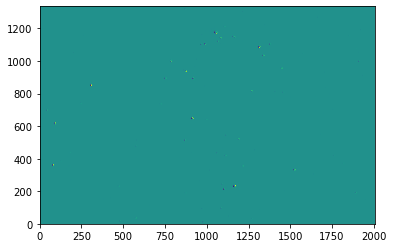

In [180]:
im1 = fits.getdata(B_final[0][0])
im2 = fits.getdata(B_final[0][1])
xtemp, ytemp = p.cross_image(im1, im2, 1000, 500, 800)
print(xtemp)
ytemp
plt.pcolormesh(im1-im2)
p.shift_image

In [151]:
def move_all(master_dir):    
    for root, dirs, files in os.walk(master_dir):
            for i in dirs:
                if '2021' in i:
                    science_paths = []
                    science_path_B = master_dir +"/"+i+"/ReducedB"
                    science_path_U = master_dir +"/"+i+"/ReducedU"
                    science_path_I = master_dir +"/"+i+"/ReducedI"
                    science_path_V = master_dir +"/"+i+"/ReducedV"
                    science_path_R = master_dir +"/"+i+"/ReducedR"
                    science_paths.append(science_path_B)
                    science_paths.append(science_path_U)
                    science_paths.append(science_path_I)
                    science_paths.append(science_path_R)
                    science_paths.append(science_path_V)
                    for y in science_paths:
                        os.chdir(y)
                        test_list = glob.glob('fd*.fit')
                        if len(test_list) == 0:
                            continue
                        else:
                            for l in test_list:
                                if fits.getheader(l)['FILTER'] == 'B':
                                    Path(science_path_B + '/' + l).rename(master_dir + '/all_images/'+l)
                                elif fits.getheader(l)['FILTER'] == 'I':
                                    Path(science_path_I + '/' + l).rename(master_dir + '/all_images/'+l)
                                elif fits.getheader(l)['FILTER'] == 'U':
                                    Path(science_path_U + '/' + l).rename(master_dir + '/all_images/'+l)
                                elif fits.getheader(l)['FILTER'] == 'V':
                                    Path(science_path_V + '/' + l).rename(master_dir + '/all_images/'+l)
                                elif fits.getheader(l)['FILTER'] == 'R':
                                    Path(science_path_R + '/' + l).rename(master_dir + '/all_images/'+l)

In [154]:
move_all(master_dir)

In [156]:
os.chdir('C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/light curves/all_images')
import datetime as dt
merged_list = glob.glob('*.fit')
def get_time_taken(im):
    return dt.datetime.strptime(im.split('-')[4] + im.split('-')[5], '%Y%m%d%H%M%S')
#     else:
#         return dt.datetime.strptime(im[1][-36:46], '%Y-%m-%d-%H%-M%S')
# creating lists for each filter of lists, those lists being each repeat of 6 or less
# print(merged_list[60][-36:46].insert(2, ' '))
# string_to_add = merged_list[]
# string_text = merged_list[60][-36:46]
# string_text = insert_dash(string_text, 4)
# string_text = insert_dash(string_text, 7)
# string_text = insert_dash(string_text, 13)
# string_text = insert_dash(string_text, 16)
# print(string_text)
B,U,I,V,R = [],[],[],[],[]
old_filter = 'B'
T0 = get_time_taken(merged_list[0]).timestamp()

for file in merged_list:
    filt = file.split('-')[6]
    delT = 0
    current_list = []
    if filt == 'B':
#         if delT < 900 and filt == old_filter:
#             current_list.append(file)
#         else: 
#             B.append(current_list)
#             current_list = [file]
        if len(B) == 0:
            B.append(current_list)
        elif filt == old_filter and delT < 900:
            B[-1].append(file)
        else:
            B.append(current_list)
    if filt == 'U':
        if len(U) == 0:
            U.append(current_list)
        elif filt == old_filter and delT < 900:
            U[-1].append(file)
        else:
            U.append(current_list)
    if filt == 'I':
        if len(I) == 0:
            I.append(current_list)
        elif filt == old_filter and delT < 900:
            I[-1].append(file)
        else:
            I.append(current_list)
    if filt == 'V':
        if len(V) == 0:
            V.append(current_list)
        elif filt == old_filter and delT < 900:
            V[-1].append(file)
        else:
            V.append(current_list)
    if filt == 'R':
        if len(R) == 0:
            R.append(current_list)
        elif filt == old_filter and delT < 900:
            R[-1].append(file)
        else:
            R.append(current_list)
    delT = (get_time_taken(file)).timestamp() - T0
    T0 = (get_time_taken(file)).timestamp()
    current_list.append(file)
    old_filter = filt
    
    

In [157]:
# np.savetxt('merged_list.csv',merged_list)
B = glob.glob('*B-BIN2*.fit')
B_final = []
b_len = len(B)
current_list = []
for i in np.arange(b_len):
    current_list.append(B[i])
    if i != b_len-1:
        if float(B[i+1].split('-')[10][0:3]) != (float(B[i].split('-')[10][0:3]) + 1):
            B_final.append(current_list)
            current_list = []
    

In [165]:
B_final
U_final = U
I_final = I
R_final = R
V_final = V

In [35]:
alignandcombineBband_no_bias_new_format(B_final)

['fdraw-T11-smithcollege-Cone Nebula-20210306-190531-B-BIN2-E-100-001.fit', 'fdraw-T11-smithcollege-Cone Nebula-20210306-190822-B-BIN2-E-100-002.fit']
[0.0, -0.018216128964667178]
[0.0, 3.7509207688015067]
[0.0, -0.018216128964667178]
[0.0, 3.7509207688015067]
['fdraw-T11-smithcollege-Cone Nebula-20210306-191314-B-BIN2-E-100-001.fit', 'fdraw-T11-smithcollege-Cone Nebula-20210306-191530-B-BIN2-E-100-002.fit', 'fdraw-T11-smithcollege-Cone Nebula-20210306-191746-B-BIN2-E-100-003.fit', 'fdraw-T11-smithcollege-Cone Nebula-20210306-192006-B-BIN2-E-100-004.fit', 'fdraw-T11-smithcollege-Cone Nebula-20210306-192224-B-BIN2-E-100-005.fit', 'fdraw-T11-smithcollege-Cone Nebula-20210306-192438-B-BIN2-E-100-006.fit']
[0.0, 0.17033366592210086, -0.019329224034237313, 0.7719372166560277, -0.7271939441057782, -0.7130898998467501]
[0.0, -7.9144524662111735, 5.1727920542062975, -10.007952026338558, -7.182309619802936, -11.116414232978286]
[0.0, 0.17033366592210086, -0.019329224034237313, 0.771937216656027

[0.0, -0.2039147107859094, -0.08628521937501432, 0.17227430134406063, -0.21662054057156865, -0.30523107511058356]
[0.0, 1.8135583974280962, -3.2962729284240595, -4.9692557689397745, 13.745409905102179, 7.992739817563461]
[0.0, -0.2039147107859094, -0.08628521937501432, 0.17227430134406063, -0.21662054057156865, -0.30523107511058356]
[0.0, 1.8135583974280962, -3.2962729284240595, -4.9692557689397745, 13.745409905102179, 7.992739817563461]
['fdraw-T11-smithcollege-NGC2264-20210223-200106-B-BIN2-E-100-001.fit', 'fdraw-T11-smithcollege-NGC2264-20210223-200334-B-BIN2-E-100-002.fit', 'fdraw-T11-smithcollege-NGC2264-20210223-200952-B-BIN2-E-100-003.fit', 'fdraw-T11-smithcollege-NGC2264-20210223-201221-B-BIN2-E-100-004.fit', 'fdraw-T11-smithcollege-NGC2264-20210223-201433-B-BIN2-E-100-005.fit', 'fdraw-T11-smithcollege-NGC2264-20210223-201635-B-BIN2-E-100-006.fit']
[0.0, 0.057362157198014074, 0.7217065294507279, 0.9685305852767954, 0.8658165662315582, 0.8908642628835821]
[0.0, -3.94075281272887

[0.0, -1.066366319580311, -0.8397751475974928, -0.6721721637390488, -1.1399824086093133, -1.2888656155350873]
[0.0, 1.8483738929521678, 1.8608392554932607, 7.795947878880838, -2.1550753842832364, 8.021629683179412]
[0.0, -1.066366319580311, -0.8397751475974928, -0.6721721637390488, -1.1399824086093133, -1.2888656155350873]
[0.0, 1.8483738929521678, 1.8608392554932607, 7.795947878880838, -2.1550753842832364, 8.021629683179412]
['fdraw-T11-smithcollege-NGC2264-20210225-221952-B-BIN2-W-100-001.fit', 'fdraw-T11-smithcollege-NGC2264-20210225-222221-B-BIN2-W-100-002.fit', 'fdraw-T11-smithcollege-NGC2264-20210225-222431-B-BIN2-W-100-003.fit', 'fdraw-T11-smithcollege-NGC2264-20210225-222640-B-BIN2-W-100-004.fit', 'fdraw-T11-smithcollege-NGC2264-20210225-222851-B-BIN2-W-100-005.fit', 'fdraw-T11-smithcollege-NGC2264-20210225-223100-B-BIN2-W-100-006.fit']
[0.0, 1.0523257191325115, -0.006793185671057245, 0.7922982181444809, 0.25181697947064663, 0.032604727892561414]
[0.0, 1.0748593408198985, 7.226

[0.0, 0.7299123577026876, -0.6577087635215548, -0.65170506910178, -1.0614193274240336, -2.032725471769794]
[0.0, -3.959999859838149, 6.089435764379118, 2.071071585508207, 6.149655303506393, -1.7240356438832123]
[0.0, 0.7299123577026876, -0.6577087635215548, -0.65170506910178, -1.0614193274240336, -2.032725471769794]
[0.0, -3.959999859838149, 6.089435764379118, 2.071071585508207, 6.149655303506393, -1.7240356438832123]
['fdraw-T11-smithcollege-NGC2264-20210228-200212-B-BIN2-E-100-001.fit', 'fdraw-T11-smithcollege-NGC2264-20210228-200459-B-BIN2-E-100-002.fit', 'fdraw-T11-smithcollege-NGC2264-20210228-200704-B-BIN2-E-100-003.fit', 'fdraw-T11-smithcollege-NGC2264-20210228-200912-B-BIN2-E-100-004.fit', 'fdraw-T11-smithcollege-NGC2264-20210228-201122-B-BIN2-E-100-005.fit', 'fdraw-T11-smithcollege-NGC2264-20210228-201326-B-BIN2-E-100-006.fit']
[0.0, -0.6709848167711243, -0.6901731522100647, -0.8795385522252559, -0.9031376459290072, -0.9720181004780954]
[0.0, -0.24372516678772627, -0.312812274

[0.0, -0.7421710375550674, -0.7256151681844756, -0.7652570903520939, -1.143094988925725, -1.121539912585348]
[0.0, 4.139232253650448, 7.213368811235227, -1.9080896446104134, 8.045685486486832, 10.064108147034176]
[0.0, -0.7421710375550674, -0.7256151681844756, -0.7652570903520939, -1.143094988925725, -1.121539912585348]
[0.0, 4.139232253650448, 7.213368811235227, -1.9080896446104134, 8.045685486486832, 10.064108147034176]
['fdraw-T11-smithcollege-NGC2264-20210310-205345-B-BIN2-W-100-001.fit', 'fdraw-T11-smithcollege-NGC2264-20210310-205626-B-BIN2-W-100-002.fit', 'fdraw-T11-smithcollege-NGC2264-20210310-205840-B-BIN2-W-100-003.fit', 'fdraw-T11-smithcollege-NGC2264-20210310-210103-B-BIN2-W-100-004.fit', 'fdraw-T11-smithcollege-NGC2264-20210310-210332-B-BIN2-W-100-005.fit', 'fdraw-T11-smithcollege-NGC2264-20210310-210550-B-BIN2-W-100-006.fit']
[0.0, -0.04119223148950368, 0.051787155217567715, -0.8517436274899808, -0.18439823600095906, -2.248364857603292]
[0.0, 2.703032585799292, 14.873392

[0.0, -1.2365681093384353, -1.1301526775296509, -0.7977807191998636, -1.218497532385328, -1.7903992204869894]
[0.0, 11.80664477991263, -3.0947204857653787, -0.7497107114559185, 4.028032964129011, -5.050696779156283]
[0.0, -1.2365681093384353, -1.1301526775296509, -0.7977807191998636, -1.218497532385328, -1.7903992204869894]
[0.0, 11.80664477991263, -3.0947204857653787, -0.7497107114559185, 4.028032964129011, -5.050696779156283]
['fdraw-T11-smithcollege-NGC2264-20210315-214405-B-BIN2-W-100-001.fit', 'fdraw-T11-smithcollege-NGC2264-20210315-214640-B-BIN2-W-100-002.fit', 'fdraw-T11-smithcollege-NGC2264-20210315-214850-B-BIN2-W-100-003.fit', 'fdraw-T11-smithcollege-NGC2264-20210315-215101-B-BIN2-W-100-004.fit', 'fdraw-T11-smithcollege-NGC2264-20210315-215315-B-BIN2-W-100-005.fit', 'fdraw-T11-smithcollege-NGC2264-20210315-215530-B-BIN2-W-100-006.fit']
[0.0, 0.1322523654462202, 0.09236206948907011, -1.7653169102781021, -2.6923201219441353, -2.3114607603302773]
[0.0, 9.177365473513532, 11.269

[0.0, -0.893522694827567, 0.06265492349689339, -1.5915493447708116, -1.7726143080069505, -1.8004546578551697]
[0.0, 10.040481082227984, 7.2599441502081845, 4.323659566550873, -1.1288623080695288, -2.7974670788718186]
[0.0, -0.893522694827567, 0.06265492349689339, -1.5915493447708116, -1.7726143080069505, -1.8004546578551697]
[0.0, 10.040481082227984, 7.2599441502081845, 4.323659566550873, -1.1288623080695288, -2.7974670788718186]
['fdraw-T11-smithcollege-NGC2264-20210319-220549-B-BIN2-W-100-001.fit', 'fdraw-T11-smithcollege-NGC2264-20210319-220817-B-BIN2-W-100-002.fit', 'fdraw-T11-smithcollege-NGC2264-20210319-221027-B-BIN2-W-100-003.fit', 'fdraw-T11-smithcollege-NGC2264-20210319-221236-B-BIN2-W-100-004.fit', 'fdraw-T11-smithcollege-NGC2264-20210319-221446-B-BIN2-W-100-005.fit', 'fdraw-T11-smithcollege-NGC2264-20210319-221657-B-BIN2-W-100-006.fit']
[0.0, -0.6335377027001527, -2.1970284170953107, -0.7227720037306256, -2.7258044529650363, -2.838402607188385]
[0.0, 3.1643003587408884, 7.7

[0.0, -0.10965136157074085, -1.0160738945147614, 0.07546548479518833, 0.9892960928875141, -0.2955464811954016]
[0.0, -11.709477228714832, -12.214072946826946, -2.2864903570470005, 3.179415865199985, 0.04954133394244309]
[0.0, -0.10965136157074085, -1.0160738945147614, 0.07546548479518833, 0.9892960928875141, -0.2955464811954016]
[0.0, -11.709477228714832, -12.214072946826946, -2.2864903570470005, 3.179415865199985, 0.04954133394244309]
['fdraw-T11-smithcollege-NGC2264-20210322-224848-B-BIN2-W-100-001.fit', 'fdraw-T11-smithcollege-NGC2264-20210322-225117-B-BIN2-W-100-002.fit', 'fdraw-T11-smithcollege-NGC2264-20210322-225327-B-BIN2-W-100-003.fit', 'fdraw-T11-smithcollege-NGC2264-20210322-225537-B-BIN2-W-100-004.fit', 'fdraw-T11-smithcollege-NGC2264-20210322-225748-B-BIN2-W-100-005.fit', 'fdraw-T11-smithcollege-NGC2264-20210322-230001-B-BIN2-W-100-006.fit']
[0.0, 1.2228355826653399, 1.242150726899041, 1.1675811441783424, -0.017977032428660777, 0.809731822198529]
[0.0, -0.9962980194901547,

In [177]:
import pdb
def alignandcombineBband_no_bias_new_format(B_list):
    os.chdir('C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/light curves/all_images')
    length_b = len(B_list)
    for i in np.arange(length_b):
        lightslist = B_list[i]
        print(lightslist)
        xshift = []
        yshift = []
        for j in lightslist:
            reference_image = lightslist[0]
            if 'BIN2-W' in reference_image:
                initial_state = 'BIN2-W'
            elif 'BIN2-E' in reference_image:
                initial_state = 'BIN2-E'
            if initial_state in j:
                x_temp, y_temp = p.cross_image(fits.getdata(reference_image), fits.getdata(j), 1000, 500, 800)
                xshift.append(x_temp)
                yshift.append(y_temp)
            else:
                flipped = fits.getdata(j)[::-1,::-1]
                x_temp, y_temp = p.cross_image(fits.getdata(reference_image),flipped, 1000, 500, 800)
                xshift.append(x_temp)
                yshift.append(y_temp)
        print(xshift)
        print(yshift)
        reference_image = lightslist[0]
        for k in np.arange(len(lightslist)):
            if 'BIN2-W' in reference_image:
                initial_state = 'BIN2-W'
            elif 'BIN2-E' in reference_image:
                initial_state = 'BIN2-E'
            if initial_state in lightslist[k]:
                header = fits.getheader(lightslist[k])
                fits.writeto('shifted' + lightslist[k], p.shift_image(fits.getdata(lightslist[k]), xshift[k], yshift[k]), header, overwrite=True)
            else:
                header = fits.getheader(lightslist[k])
                fits.writeto('shifted' + lightslist[k], p.shift_image(fits.getdata(lightslist[k])[::-1,::-1], xshift[k], yshift[k]), header, overwrite=True)
        shiftedlist = glob.glob('shifted*.fit')
        print(shiftedlist)
        fits.writeto(initial_state + ' MasterScience_B' + str(i) + '.fit', mediancombinescience(shiftedlist), header, overwrite=True)
        files_to_remove = glob.glob('shifted*.fit')
        print(xshift)
        print(yshift)
        for f in files_to_remove:
            os.remove(f)
def alignandcombineVband_no_bias_new_format(V_list):
    os.chdir('C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/light curves/all_images')
    length_b = len(V_list)
    for i in np.arange(length_b):
        lightslist = V_list[i]
        print(lightslist)
        xshift = []
        yshift = []
        for j in lightslist:
            reference_image = lightslist[0]
            if 'BIN2-W' in reference_image:
                initial_state = 'BIN2-W'
            elif 'BIN2-E' in reference_image:
                initial_state = 'BIN2-E'
            if initial_state in j:
                x_temp, y_temp = p.cross_image(fits.getdata(reference_image), fits.getdata(j), 1000, 500, 800)
                xshift.append(x_temp)
                yshift.append(y_temp)
            else:
                flipped = fits.getdata(j)[::-1,::-1]
                x_temp, y_temp = p.cross_image(fits.getdata(reference_image),flipped, 1000, 500, 800)
                xshift.append(x_temp)
                yshift.append(y_temp)
        print(xshift)
        print(yshift)
        reference_image = lightslist[0]
        for k in np.arange(len(lightslist)):
            if 'BIN2-W' in reference_image:
                initial_state = 'BIN2-W'
            elif 'BIN2-E' in reference_image:
                initial_state = 'BIN2-E'
            if initial_state in lightslist[k]:
                header = fits.getheader(lightslist[k])
                fits.writeto('shifted' + lightslist[k], p.shift_image(fits.getdata(lightslist[k]), xshift[k], yshift[k]), header, overwrite=True)
            else:
                header = fits.getheader(lightslist[k])
                fits.writeto('shifted' + lightslist[k], p.shift_image(fits.getdata(lightslist[k])[::-1,::-1], xshift[k], yshift[k]), header, overwrite=True)
        shiftedlist = glob.glob('shifted*.fit')
        print(shiftedlist)
        fits.writeto(initial_state + ' MasterScience_V' + str(i) + '.fit', mediancombinescience(shiftedlist), header, overwrite=True)
        files_to_remove = glob.glob('shifted*.fit')
        print(xshift)
        print(yshift)
        for f in files_to_remove:
            os.remove(f)
def alignandcombineRband_no_bias_new_format(R_list):
    os.chdir('C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/light curves/all_images')
    length_b = len(R_list)
    for i in np.arange(length_b):
        lightslist = R_list[i]
        print(lightslist)
        xshift = []
        yshift = []
        for j in lightslist:
            reference_image = lightslist[0]
            if 'BIN2-W' in reference_image:
                initial_state = 'BIN2-W'
            elif 'BIN2-E' in reference_image:
                initial_state = 'BIN2-E'
            if initial_state in j:
                x_temp, y_temp = p.cross_image(fits.getdata(reference_image), fits.getdata(j), 1000, 500, 800)
                xshift.append(x_temp)
                yshift.append(y_temp)
            else:
                flipped = fits.getdata(j)[::-1,::-1]
                x_temp, y_temp = p.cross_image(fits.getdata(reference_image),flipped, 1000, 500, 800)
                xshift.append(x_temp)
                yshift.append(y_temp)
        print(xshift)
        print(yshift)
        reference_image = lightslist[0]
        for k in np.arange(len(lightslist)):
            if 'BIN2-W' in reference_image:
                initial_state = 'BIN2-W'
            elif 'BIN2-E' in reference_image:
                initial_state = 'BIN2-E'
            if initial_state in lightslist[k]:
                header = fits.getheader(lightslist[k])
                fits.writeto('shifted' + lightslist[k], p.shift_image(fits.getdata(lightslist[k]), xshift[k], yshift[k]), header, overwrite=True)
            else:
                header = fits.getheader(lightslist[k])
                fits.writeto('shifted' + lightslist[k], p.shift_image(fits.getdata(lightslist[k])[::-1,::-1], xshift[k], yshift[k]), header, overwrite=True)
        shiftedlist = glob.glob('shifted*.fit')
        print(shiftedlist)
        fits.writeto(initial_state + ' MasterScience_R' + str(i) + '.fit', mediancombinescience(shiftedlist), header, overwrite=True)
        files_to_remove = glob.glob('shifted*.fit')
        print(xshift)
        print(yshift)
        for f in files_to_remove:
            os.remove(f)
def alignandcombineIband_no_bias_new_format(I_list):
    os.chdir('C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/light curves/all_images')
    length_b = len(I_list)
    for i in np.arange(length_b):
        lightslist = I_list[i]
        print(lightslist)
        xshift = []
        yshift = []
        for j in lightslist:
            reference_image = lightslist[0]
            if 'BIN2-W' in reference_image:
                initial_state = 'BIN2-W'
            elif 'BIN2-E' in reference_image:
                initial_state = 'BIN2-E'
            if initial_state in j:
                x_temp, y_temp = p.cross_image(fits.getdata(reference_image), fits.getdata(j), 1000, 500, 800)
                xshift.append(x_temp)
                yshift.append(y_temp)
            else:
                flipped = fits.getdata(j)[::-1,::-1]
                x_temp, y_temp = p.cross_image(fits.getdata(reference_image),flipped, 1000, 500, 800)
                xshift.append(x_temp)
                yshift.append(y_temp)
        print(xshift)
        print(yshift)
        reference_image = lightslist[0]
        for k in np.arange(len(lightslist)):
            if 'BIN2-W' in reference_image:
                initial_state = 'BIN2-W'
            elif 'BIN2-E' in reference_image:
                initial_state = 'BIN2-E'
            if initial_state in lightslist[k]:
                header = fits.getheader(lightslist[k])
                fits.writeto('shifted' + lightslist[k], p.shift_image(fits.getdata(lightslist[k]), xshift[k], yshift[k]), header, overwrite=True)
            else:
                header = fits.getheader(lightslist[k])
                fits.writeto('shifted' + lightslist[k], p.shift_image(fits.getdata(lightslist[k])[::-1,::-1], xshift[k], yshift[k]), header, overwrite=True)
        shiftedlist = glob.glob('shifted*.fit')
        print(shiftedlist)
        fits.writeto(initial_state + ' MasterScience_I' + str(i) + '.fit', mediancombinescience(shiftedlist), header, overwrite=True)
        files_to_remove = glob.glob('shifted*.fit')
        print(xshift)
        print(yshift)
        for f in files_to_remove:
            os.remove(f)
def alignandcombineUband_no_bias_new_format(U_list):
    os.chdir('C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/light curves/all_images')
    length_b = len(U_list)
    for i in np.arange(length_b):
        lightslist = U_list[i]
        print(lightslist)
        xshift = []
        yshift = []
        for j in lightslist:
            reference_image = lightslist[0]
            if 'BIN2-W' in reference_image:
                initial_state = 'BIN2-W'
            elif 'BIN2-E' in reference_image:
                initial_state = 'BIN2-E'
            if initial_state in j:
                x_temp, y_temp = p.cross_image(fits.getdata(reference_image), fits.getdata(j), 1000, 500, 800)
                xshift.append(x_temp)
                yshift.append(y_temp)
            else:
                flipped = fits.getdata(j)[::-1,::-1]
                x_temp, y_temp = p.cross_image(fits.getdata(reference_image),flipped, 1000, 500, 800)
                xshift.append(x_temp)
                yshift.append(y_temp)
        print(xshift)
        print(yshift)
        reference_image = lightslist[0]
        for k in np.arange(len(lightslist)):
            if 'BIN2-W' in reference_image:
                initial_state = 'BIN2-W'
            elif 'BIN2-E' in reference_image:
                initial_state = 'BIN2-E'
            if initial_state in lightslist[k]:
                header = fits.getheader(lightslist[k])
                fits.writeto('shifted' + lightslist[k], p.shift_image(fits.getdata(lightslist[k]), xshift[k], yshift[k]), header, overwrite=True)
            else:
                header = fits.getheader(lightslist[k])
                fits.writeto('shifted' + lightslist[k], p.shift_image(fits.getdata(lightslist[k])[::-1,::-1], xshift[k], yshift[k]), header, overwrite=True)
        shiftedlist = glob.glob('shifted*.fit')
        print(shiftedlist)
        fits.writeto(initial_state + ' MasterScience_U' + str(i) + '.fit', mediancombinescience(shiftedlist), header, overwrite=True)
        files_to_remove = glob.glob('shifted*.fit')
        print(xshift)
        print(yshift)
        for f in files_to_remove:
            os.remove(f)

In [169]:
alignandcombineVband_no_bias_new_format(V_final)

['fdraw-T11-smithcollege-Cone Nebula-20210306-192656-V-BIN2-E-060-001.fit', 'fdraw-T11-smithcollege-Cone Nebula-20210306-192838-V-BIN2-E-060-002.fit', 'fdraw-T11-smithcollege-Cone Nebula-20210306-193008-V-BIN2-E-060-003.fit', 'fdraw-T11-smithcollege-Cone Nebula-20210306-193136-V-BIN2-E-060-004.fit', 'fdraw-T11-smithcollege-Cone Nebula-20210306-193256-V-BIN2-E-060-005.fit', 'fdraw-T11-smithcollege-Cone Nebula-20210306-193828-V-BIN2-E-060-006.fit']
[0.0, 0.8735929565218896, -0.36861730951574145, -0.27719671077426256, -0.6296151213460348, 98.10723368083174]
[0.0, -0.1306728525555627, -1.192727338727309, -1.6421012509548518, -1.2450432566114387, 6.665573007370085]
['shiftedfdraw-T11-smithcollege-Cone Nebula-20210306-192656-V-BIN2-E-060-001.fit', 'shiftedfdraw-T11-smithcollege-Cone Nebula-20210306-192838-V-BIN2-E-060-002.fit', 'shiftedfdraw-T11-smithcollege-Cone Nebula-20210306-193008-V-BIN2-E-060-003.fit', 'shiftedfdraw-T11-smithcollege-Cone Nebula-20210306-193136-V-BIN2-E-060-004.fit', 's

[0.0, -1.866206845462898, -1.198486326470345, -0.7977719652299982, -1.1977375684742242, -2.8138015613574225]
[0.0, 2.0474714619481347, -7.133615576058901, 2.732635760171206, 0.9266225634954708, 2.8336773690923565]
['shiftedfdraw-T11-smithcollege-NGC2264-20210222-214935-V-BIN2-W-060-001.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210222-215112-V-BIN2-W-060-002.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210222-215239-V-BIN2-W-060-003.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210222-215405-V-BIN2-W-060-004.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210222-215533-V-BIN2-W-060-005.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210222-215657-V-BIN2-W-060-006.fit']
[0.0, -1.866206845462898, -1.198486326470345, -0.7977719652299982, -1.1977375684742242, -2.8138015613574225]
[0.0, 2.0474714619481347, -7.133615576058901, 2.732635760171206, 0.9266225634954708, 2.8336773690923565]
['fdraw-T11-smithcollege-NGC2264-20210222-221819-V-BIN2-W-060-001.fit', 'fdraw-T11-smithcollege-NGC2264

[0.0, -0.2972115135417255, -1.1048301197245394, -1.933599429516903, -1.6742762796760644, -3.0102900139312396]
[0.0, -8.999597139699745, -1.163174896604687, -4.247826089399155, -4.924545984243764, -2.996701517259453]
['fdraw-T11-smithcollege-NGC2264-20210224-222340-V-BIN2-W-060-001.fit', 'fdraw-T11-smithcollege-NGC2264-20210224-222518-V-BIN2-W-060-002.fit', 'fdraw-T11-smithcollege-NGC2264-20210224-222643-V-BIN2-W-060-003.fit', 'fdraw-T11-smithcollege-NGC2264-20210224-222806-V-BIN2-W-060-004.fit', 'fdraw-T11-smithcollege-NGC2264-20210224-222930-V-BIN2-W-060-005.fit', 'fdraw-T11-smithcollege-NGC2264-20210224-223057-V-BIN2-W-060-006.fit']
[0.0, 0.0023053747519270473, -0.6378259793237362, -0.11949743824303027, -0.8134843410452106, -0.9660165105095473]
[0.0, 11.111800489220059, -2.855450236305046, 7.8432102159509896, -1.7735814859933043, 4.190836496640372]
['shiftedfdraw-T11-smithcollege-NGC2264-20210224-222340-V-BIN2-W-060-001.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210224-222518-V-B

[0.0, -0.7664747340917302]
[0.0, -3.8651856096156507]
['fdraw-T11-smithcollege-NGC2264-20210225-223310-V-BIN2-W-060-001.fit', 'fdraw-T11-smithcollege-NGC2264-20210225-223449-V-BIN2-W-060-002.fit', 'fdraw-T11-smithcollege-NGC2264-20210225-223612-V-BIN2-W-060-003.fit', 'fdraw-T11-smithcollege-NGC2264-20210225-223736-V-BIN2-W-060-004.fit', 'fdraw-T11-smithcollege-NGC2264-20210225-223859-V-BIN2-W-060-005.fit', 'fdraw-T11-smithcollege-NGC2264-20210225-224026-V-BIN2-W-060-006.fit']
[0.0, 0.26246753960973024, 0.7677100588607857, 0.7693037374191078, -0.0761445006517647, -0.9857805878286854]
[0.0, 5.130416074396749, 8.289365088291902, 9.037371895874116, 12.021520235682146, 1.7899820662130423]
['shiftedfdraw-T11-smithcollege-NGC2264-20210225-223310-V-BIN2-W-060-001.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210225-223449-V-BIN2-W-060-002.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210225-223612-V-BIN2-W-060-003.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210225-223736-V-BIN2-W-060-004.

[0.0, 0.06002975536040367, 1.3318203954881653, -0.11800817995964508, 0.07353473943192057, 0.7166841474652585]
[0.0, -3.894395674282805, -2.7188748280035497, -10.721973699178648, -1.1808486052859735, 4.165175776304636]
['shiftedfdraw-T11-smithcollege-NGC2264-20210226-212022-V-BIN2-W-060-001.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210226-212205-V-BIN2-W-060-002.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210226-212330-V-BIN2-W-060-003.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210226-212501-V-BIN2-W-060-004.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210226-212631-V-BIN2-W-060-005.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210226-212759-V-BIN2-W-060-006.fit']
[0.0, 0.06002975536040367, 1.3318203954881653, -0.11800817995964508, 0.07353473943192057, 0.7166841474652585]
[0.0, -3.894395674282805, -2.7188748280035497, -10.721973699178648, -1.1808486052859735, 4.165175776304636]
['fdraw-T11-smithcollege-NGC2264-20210226-215718-V-BIN2-W-060-001.fit', 'fdraw-T11-smithcollege

[0.0, -0.3729836721028619, -1.0686357518698912, -1.7969915163184282, -1.9327555238070318, -0.9971471689028704]
[0.0, -2.0642425204603114, -9.790866597831382, -4.761514284882651, -3.8126334170949576, 8.938428171386022]
['fdraw-T11-smithcollege-NGC2264-20210301-214047-V-BIN2-W-060-001.fit', 'fdraw-T11-smithcollege-NGC2264-20210301-214227-V-BIN2-W-060-002.fit', 'fdraw-T11-smithcollege-NGC2264-20210301-214349-V-BIN2-W-060-003.fit', 'fdraw-T11-smithcollege-NGC2264-20210301-214512-V-BIN2-W-060-004.fit', 'fdraw-T11-smithcollege-NGC2264-20210301-214636-V-BIN2-W-060-005.fit', 'fdraw-T11-smithcollege-NGC2264-20210301-214801-V-BIN2-W-060-006.fit']
[0.0, 0.11837188182317959, 0.16228151145418224, 0.20064412716160973, 0.010669582312033299, -1.6837743525926783]
[0.0, -10.201078972345954, -13.773841526680826, -7.643103578238083, -13.837325788062003, -15.758283086687925]
['shiftedfdraw-T11-smithcollege-NGC2264-20210301-214047-V-BIN2-W-060-001.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210301-214227

[0.0, 0.7718598075838372, 1.0712625437052736, 0.6819056489331388, -0.9839583212388732, -0.008989994135333745]
[0.0, -16.269530487061957, 1.0814610429795266, -3.373241492933289, -13.67768467865801, -3.967896759315522]
['shiftedfdraw-T11-smithcollege-NGC2264-20210310-213934-V-BIN2-W-060-001.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210310-214122-V-BIN2-W-060-002.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210310-214257-V-BIN2-W-060-003.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210310-214435-V-BIN2-W-060-004.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210310-214613-V-BIN2-W-060-005.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210310-214750-V-BIN2-W-060-006.fit']
[0.0, 0.7718598075838372, 1.0712625437052736, 0.6819056489331388, -0.9839583212388732, -0.008989994135333745]
[0.0, -16.269530487061957, 1.0814610429795266, -3.373241492933289, -13.67768467865801, -3.967896759315522]
['fdraw-T11-smithcollege-NGC2264-20210310-221244-V-BIN2-W-060-001.fit', 'fdraw-T11-smithcollege-N

[0.0, 0.32335583177334115, 0.2763152693133861, 0.03859436464543364, -0.311341246719536, -1.8286049152656574]
[0.0, 5.1197814166596345, -10.732557850026865, -8.679133673380647, -5.138024921334022, -7.298346844404591]
['shiftedfdraw-T11-smithcollege-NGC2264-20210315-205349-V-BIN2-W-060-001.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210315-205531-V-BIN2-W-060-002.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210315-205659-V-BIN2-W-060-003.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210315-205827-V-BIN2-W-060-004.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210315-205957-V-BIN2-W-060-005.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210315-210123-V-BIN2-W-060-006.fit']
[0.0, 0.32335583177334115, 0.2763152693133861, 0.03859436464543364, -0.311341246719536, -1.8286049152656574]
[0.0, 5.1197814166596345, -10.732557850026865, -8.679133673380647, -5.138024921334022, -7.298346844404591]
['fdraw-T11-smithcollege-NGC2264-20210315-212325-V-BIN2-W-060-001.fit', 'fdraw-T11-smithcollege-NGC

['shiftedfdraw-T11-smithcollege-NGC2264-20210318-221902-V-BIN2-W-060-001.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210318-222036-V-BIN2-W-060-002.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210318-222200-V-BIN2-W-060-003.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210318-222326-V-BIN2-W-060-004.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210318-222451-V-BIN2-W-060-005.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210318-222616-V-BIN2-W-060-006.fit']
[0.0, 0.020191835138149372, -1.8482251564660714, -1.85515629126337, -0.9366540800528185, -0.3315368146936919]
[0.0, 2.9776421277745158, 4.101018807746868, -2.9702943329818936, 0.08032522600763059, 9.68725340931087]
['fdraw-T11-smithcollege-NGC2264-20210318-224726-V-BIN2-W-060-001.fit', 'fdraw-T11-smithcollege-NGC2264-20210318-224900-V-BIN2-W-060-002.fit', 'fdraw-T11-smithcollege-NGC2264-20210318-225022-V-BIN2-W-060-003.fit', 'fdraw-T11-smithcollege-NGC2264-20210318-225145-V-BIN2-W-060-004.fit', 'fdraw-T11-smithcollege-NGC2264

[0.0, 0.9171608039432044, -0.8199132125426729, 1.0561528113173893, 0.6992586855896832, 0.6628847979738737]
[0.0, 3.0858735504016295, 2.774308633881901, 11.852197396107044, 1.0775100686427095, 4.9317568279032]
['fdraw-T11-smithcollege-NGC2264-20210319-232113-V-BIN2-W-060-001.fit', 'fdraw-T11-smithcollege-NGC2264-20210319-232247-V-BIN2-W-060-002.fit']
[0.0, -0.01789897888849623]
[0.0, -3.858375297413886]
['shiftedfdraw-T11-smithcollege-NGC2264-20210319-232113-V-BIN2-W-060-001.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210319-232247-V-BIN2-W-060-002.fit']
[0.0, -0.01789897888849623]
[0.0, -3.858375297413886]
['fdraw-T11-smithcollege-NGC2264-20210320-204819-V-BIN2-W-060-001.fit', 'fdraw-T11-smithcollege-NGC2264-20210320-204957-V-BIN2-W-060-002.fit', 'fdraw-T11-smithcollege-NGC2264-20210320-205119-V-BIN2-W-060-003.fit', 'fdraw-T11-smithcollege-NGC2264-20210320-205243-V-BIN2-W-060-004.fit', 'fdraw-T11-smithcollege-NGC2264-20210320-205409-V-BIN2-W-060-005.fit', 'fdraw-T11-smithcollege-NGC

[0.0, 1.7850024635893078, 1.3713229622970005, 1.0008037795723794, 2.12318553045921, 3.1415803556961635]
[0.0, 9.793071524556694, 1.2571635998190231, -1.272320668671341, 8.27567357646376, -4.865861353635978]
['fdraw-T11-smithcollege-NGC2264-20210322-223247-V-BIN2-W-060-001.fit', 'fdraw-T11-smithcollege-NGC2264-20210322-223436-V-BIN2-W-060-002.fit', 'fdraw-T11-smithcollege-NGC2264-20210322-223602-V-BIN2-W-060-003.fit', 'fdraw-T11-smithcollege-NGC2264-20210322-223729-V-BIN2-W-060-004.fit', 'fdraw-T11-smithcollege-NGC2264-20210322-223855-V-BIN2-W-060-005.fit', 'fdraw-T11-smithcollege-NGC2264-20210322-224023-V-BIN2-W-060-006.fit']
[0.0, -0.3477637055614764, 0.2494272048749906, 1.2987304264236457, -0.3223465633681144, 0.734100621640863]
[0.0, 0.7246391212320304, -4.210278957211699, 1.211329364448261, -2.1970127766772976, 6.135413814697131]
['shiftedfdraw-T11-smithcollege-NGC2264-20210322-223247-V-BIN2-W-060-001.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210322-223436-V-BIN2-W-060-002.fit

In [172]:
alignandcombineRband_no_bias_new_format(R_final)

['fdraw-T11-smithcollege-Cone Nebula-20210306-194007-R-BIN2-E-040-001.fit', 'fdraw-T11-smithcollege-Cone Nebula-20210306-194116-R-BIN2-E-040-002.fit', 'fdraw-T11-smithcollege-Cone Nebula-20210306-194215-R-BIN2-E-040-003.fit', 'fdraw-T11-smithcollege-Cone Nebula-20210306-194310-R-BIN2-E-040-004.fit', 'fdraw-T11-smithcollege-Cone Nebula-20210306-194408-R-BIN2-E-040-005.fit', 'fdraw-T11-smithcollege-Cone Nebula-20210306-194512-R-BIN2-E-040-006.fit']
[0.0, -0.1045471424539528, -0.12851097426306524, -0.2098043949847863, -0.12635957269304754, -0.19878148962072828]
[0.0, 0.08918987836716497, 0.025179538088082154, -0.03490759645330854, -0.05129651667834878, 0.10063605085133531]
['shiftedfdraw-T11-smithcollege-Cone Nebula-20210306-194007-R-BIN2-E-040-001.fit', 'shiftedfdraw-T11-smithcollege-Cone Nebula-20210306-194116-R-BIN2-E-040-002.fit', 'shiftedfdraw-T11-smithcollege-Cone Nebula-20210306-194215-R-BIN2-E-040-003.fit', 'shiftedfdraw-T11-smithcollege-Cone Nebula-20210306-194310-R-BIN2-E-040-00

[0.0, -0.7742900775813268, -0.950719164592499, -1.1478686448510018, 0.2511089202351968, -1.2925336507781537]
[0.0, -0.8993631186259563, 7.1986027704149365, 6.233748760402591, 8.052877362566164, 17.71023774841035]
['shiftedfdraw-T11-smithcollege-NGC2264-20210222-215824-R-BIN2-W-040-001.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210222-215937-R-BIN2-W-040-002.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210222-220042-R-BIN2-W-040-003.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210222-220147-R-BIN2-W-040-004.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210222-220254-R-BIN2-W-040-005.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210222-220359-R-BIN2-W-040-006.fit']
[0.0, -0.7742900775813268, -0.950719164592499, -1.1478686448510018, 0.2511089202351968, -1.2925336507781537]
[0.0, -0.8993631186259563, 7.1986027704149365, 6.233748760402591, 8.052877362566164, 17.71023774841035]
['fdraw-T11-smithcollege-NGC2264-20210222-222702-R-BIN2-W-040-001.fit', 'fdraw-T11-smithcollege-NGC2264-2

[0.0, -0.9251586062975434, -1.660372139183039, -1.9161352171588248, -2.095087458186299, -1.2780940772152007]
[0.0, -11.218606204807656, 4.089828509687891, 2.0952084292523523, -1.1834957629878318, -7.135623791868284]
['shiftedfdraw-T11-smithcollege-NGC2264-20210224-223221-R-BIN2-W-040-001.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210224-223331-R-BIN2-W-040-002.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210224-223435-R-BIN2-W-040-003.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210224-223538-R-BIN2-W-040-004.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210224-223641-R-BIN2-W-040-005.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210224-223744-R-BIN2-W-040-006.fit']
[0.0, -0.9251586062975434, -1.660372139183039, -1.9161352171588248, -2.095087458186299, -1.2780940772152007]
[0.0, -11.218606204807656, 4.089828509687891, 2.0952084292523523, -1.1834957629878318, -7.135623791868284]
['fdraw-T11-smithcollege-NGC2264-20210224-230049-R-BIN2-W-040-001.fit', 'fdraw-T11-smithcollege-NGC

[0.0, -1.2262488181452227, 0.6953388286285644, 0.7780025988771797, 0.12314240328174719, -0.07388087024881429]
[0.0, 4.81300399551526, 3.982631062719406, 7.7110289981945925, 7.910491767123972, 9.780213643873367]
['fdraw-T11-smithcollege-NGC2264-20210225-234333-R-BIN2-W-040-001.fit', 'fdraw-T11-smithcollege-NGC2264-20210225-234446-R-BIN2-W-040-002.fit', 'fdraw-T11-smithcollege-NGC2264-20210225-234553-R-BIN2-W-040-003.fit', 'fdraw-T11-smithcollege-NGC2264-20210225-234659-R-BIN2-W-040-004.fit', 'fdraw-T11-smithcollege-NGC2264-20210225-234807-R-BIN2-W-040-005.fit', 'fdraw-T11-smithcollege-NGC2264-20210225-234914-R-BIN2-W-040-006.fit']
[0.0, -0.06111667745904015, 0.88686307058029, 1.188295474726658, 0.9732700855905989, 1.1274116295558372]
[0.0, -5.852254408968747, -3.8829849797908764, -11.217096877720564, -3.014213707927638, -18.893527465330294]
['shiftedfdraw-T11-smithcollege-NGC2264-20210225-234333-R-BIN2-W-040-001.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210225-234446-R-BIN2-W-040-0

[0.0, -0.19159408644162568, -0.04000036793547679, -0.2240795690304367, -0.27611627612336065, -0.3091509970205095]
[0.0, 0.014838509269452516, 6.3090572436688035, -1.1396995396618195, 17.12293224753398, 11.137230640124812]
['shiftedfdraw-T11-smithcollege-NGC2264-20210226-223612-R-BIN2-W-040-001.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210226-223732-R-BIN2-W-040-002.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210226-223839-R-BIN2-W-040-003.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210226-223950-R-BIN2-W-040-004.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210226-224057-R-BIN2-W-040-005.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210226-224204-R-BIN2-W-040-006.fit']
[0.0, -0.19159408644162568, -0.04000036793547679, -0.2240795690304367, -0.27611627612336065, -0.3091509970205095]
[0.0, 0.014838509269452516, 6.3090572436688035, -1.1396995396618195, 17.12293224753398, 11.137230640124812]
['fdraw-T11-smithcollege-NGC2264-20210228-203137-R-BIN2-W-040-001.fit', 'fdraw-T11-smit

[0.0, 0.7614724426131545, -0.20094269597885273, -0.15456240259464948]
[0.0, 9.321708765151584, 5.068694505745725, 2.783514423845645]
['shiftedfdraw-T11-smithcollege-NGC2264-20210302-225445-R-BIN2-W-040-001.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210302-225604-R-BIN2-W-040-002.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210302-225713-R-BIN2-W-040-003.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210302-225819-R-BIN2-W-040-004.fit']
[0.0, 0.7614724426131545, -0.20094269597885273, -0.15456240259464948]
[0.0, 9.321708765151584, 5.068694505745725, 2.783514423845645]
['fdraw-T11-smithcollege-NGC2264-20210310-204543-R-BIN2-W-040-001.fit', 'fdraw-T11-smithcollege-NGC2264-20210310-204729-R-BIN2-W-040-002.fit', 'fdraw-T11-smithcollege-NGC2264-20210310-204838-R-BIN2-W-040-003.fit', 'fdraw-T11-smithcollege-NGC2264-20210310-204953-R-BIN2-W-040-004.fit', 'fdraw-T11-smithcollege-NGC2264-20210310-205112-R-BIN2-W-040-005.fit', 'fdraw-T11-smithcollege-NGC2264-20210310-205233-R-BIN2-W-040-006.

[0.0, -0.25548830775542797, 0.05694757275884399, -1.0166914795575508, -0.106810569803514, -0.2794155469794646]
[0.0, 5.246977200730953, -5.68685273775327, -5.2906305234141655, 1.2725874169540248, -1.2230015325254726]
['fdraw-T11-smithcollege-NGC2264-20210311-200104-R-BIN2-W-040-001.fit', 'fdraw-T11-smithcollege-NGC2264-20210311-200245-R-BIN2-W-040-002.fit', 'fdraw-T11-smithcollege-NGC2264-20210311-200404-R-BIN2-W-040-003.fit', 'fdraw-T11-smithcollege-NGC2264-20210311-200530-R-BIN2-W-040-004.fit', 'fdraw-T11-smithcollege-NGC2264-20210311-200632-R-BIN2-W-040-005.fit', 'fdraw-T11-smithcollege-NGC2264-20210311-200755-R-BIN2-W-040-006.fit']
[0.0, -0.6314172245434406, -0.0725195998560082, 0.1945749825516998, -0.39685478686638476, 0.14258769262553983]
[0.0, -8.20552808901357, -5.658394209055132, -7.26180712468863, -5.329290786588558, -0.27812593615794867]
['shiftedfdraw-T11-smithcollege-NGC2264-20210311-200104-R-BIN2-W-040-001.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210311-200245-R-BIN

[0.0, 1.126297325405318, -0.05943674252142728, -0.008496720719591622, -0.10856020720572701, -0.10494890424999426]
[0.0, 10.817241459121647, 15.925945243805131, 11.944639363384795, -0.010408314839196464, 14.192568280067917]
['shiftedfdraw-T11-smithcollege-NGC2264-20210318-212638-R-BIN2-W-040-001.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210318-212748-R-BIN2-W-040-002.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210318-212851-R-BIN2-W-040-003.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210318-212957-R-BIN2-W-040-004.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210318-213100-R-BIN2-W-040-005.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210318-213203-R-BIN2-W-040-006.fit']
[0.0, 1.126297325405318, -0.05943674252142728, -0.008496720719591622, -0.10856020720572701, -0.10494890424999426]
[0.0, 10.817241459121647, 15.925945243805131, 11.944639363384795, -0.010408314839196464, 14.192568280067917]
['fdraw-T11-smithcollege-NGC2264-20210318-215914-R-BIN2-W-040-001.fit', 'fdraw-T11-sm

['shiftedfdraw-T11-smithcollege-NGC2264-20210319-215917-R-BIN2-W-040-001.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210319-220030-R-BIN2-W-040-002.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210319-220136-R-BIN2-W-040-003.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210319-220240-R-BIN2-W-040-004.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210319-220343-R-BIN2-W-040-005.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210319-220446-R-BIN2-W-040-006.fit']
[0.0, 0.17889147944197248, -1.276890470950491, 0.6449543568263607, -0.28539982315498946, -1.0150031978943446]
[0.0, 4.718103061945953, 3.738699032579575, 11.798132238169842, -7.770916521501704, -7.007525914705184]
['fdraw-T11-smithcollege-NGC2264-20210319-222758-R-BIN2-W-040-001.fit', 'fdraw-T11-smithcollege-NGC2264-20210319-222910-R-BIN2-W-040-002.fit', 'fdraw-T11-smithcollege-NGC2264-20210319-223016-R-BIN2-W-040-003.fit', 'fdraw-T11-smithcollege-NGC2264-20210319-223125-R-BIN2-W-040-004.fit', 'fdraw-T11-smithcollege-NGC2264-

[0.0, -0.7225923126580938, 0.3544412570481086, -0.879161815545956, -1.1121948039038898, -1.6306716737716442]
[0.0, -11.29848741751448, 5.269878746798213, 2.7637783749619302, -8.050972651247662, -10.728012414372074]
['fdraw-T11-smithcollege-NGC2264-20210320-225939-R-BIN2-W-040-001.fit', 'fdraw-T11-smithcollege-NGC2264-20210320-230050-R-BIN2-W-040-002.fit', 'fdraw-T11-smithcollege-NGC2264-20210320-230154-R-BIN2-W-040-003.fit', 'fdraw-T11-smithcollege-NGC2264-20210320-230258-R-BIN2-W-040-004.fit', 'fdraw-T11-smithcollege-NGC2264-20210320-230400-R-BIN2-W-040-005.fit', 'fdraw-T11-smithcollege-NGC2264-20210320-230502-R-BIN2-W-040-006.fit']
[0.0, 0.914240144587211, 0.9878612395914956, 0.2401299680038278, 1.3921701474677093, 2.0472863240161416]
[0.0, 10.756196854767154, 6.790641663407541, 19.132562132224393, 16.217764586882936, 15.241315087063981]
['shiftedfdraw-T11-smithcollege-NGC2264-20210320-225939-R-BIN2-W-040-001.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210320-230050-R-BIN2-W-040-0

In [178]:
alignandcombineUband_no_bias_new_format(U_final)

['fdraw-T11-smithcollege-NGC2264-20210308-193019-U-BIN2-E-300-001.fit', 'fdraw-T11-smithcollege-NGC2264-20210308-193616-U-BIN2-E-300-002.fit', 'fdraw-T11-smithcollege-NGC2264-20210308-194135-U-BIN2-E-300-003.fit', 'fdraw-T11-smithcollege-NGC2264-20210308-194910-U-BIN2-W-300-004.fit']
[0.0, -0.3403330519309691, -0.7648308258586098, 25.898505840964333]
[0.0, -0.2499904016308392, -1.0423453987943958, -15.774195241850634]
['shiftedfdraw-T11-smithcollege-NGC2264-20210308-193019-U-BIN2-E-300-001.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210308-193616-U-BIN2-E-300-002.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210308-194135-U-BIN2-E-300-003.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210308-194910-U-BIN2-W-300-004.fit']
[0.0, -0.3403330519309691, -0.7648308258586098, 25.898505840964333]
[0.0, -0.2499904016308392, -1.0423453987943958, -15.774195241850634]
['fdraw-T11-smithcollege-NGC2264-20210317-203157-U-BIN2-W-300-001.fit', 'fdraw-T11-smithcollege-NGC2264-20210317-203744-U-BIN2-W

In [180]:
alignandcombineIband_no_bias_new_format(I_final)

['fdraw-T11-smithcollege-NGC2264-20210317-210922-I-BIN2-W-100-001.fit', 'fdraw-T11-smithcollege-NGC2264-20210317-211149-I-BIN2-W-100-002.fit', 'fdraw-T11-smithcollege-NGC2264-20210317-211400-I-BIN2-W-100-003.fit', 'fdraw-T11-smithcollege-NGC2264-20210317-211609-I-BIN2-W-100-004.fit', 'fdraw-T11-smithcollege-NGC2264-20210317-211820-I-BIN2-W-100-005.fit', 'fdraw-T11-smithcollege-NGC2264-20210317-212031-I-BIN2-W-100-006.fit']
[0.0, -0.16078103317570935, -0.12733452585069926, -0.3810145319023093, -0.7388943516379527, -0.9959076385715093]
[0.0, -3.808593064020556, -1.6532849767169182, -16.664146911192802, -6.860219359432449, -16.016414592798924]
['shiftedfdraw-T11-smithcollege-NGC2264-20210317-210922-I-BIN2-W-100-001.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210317-211149-I-BIN2-W-100-002.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210317-211400-I-BIN2-W-100-003.fit', 'shiftedfdraw-T11-smithcollege-NGC2264-20210317-211609-I-BIN2-W-100-004.fit', 'shiftedfdraw-T11-smithcollege-NGC2264

In [269]:
# os.chdir(master_dir + '/Master Blue')
# os.chdir(master_dir + '/Master Visual')
# os.chdir(master_dir + '/Master Red')
# os.chdir(master_dir + '/Master I')
os.chdir(master_dir + '/Master U')

In [192]:
masterlist = glob.glob('*.fit')

initial_state = 'BIN2-E'
for i in masterlist:
    if initial_state in i:
        continue
    else:
        header = fits.getheader(i)
        flipped_data = fits.getdata(i)[::-1, ::-1]
        fits.writeto(initial_state + i[6:], flipped_data, header, overwrite = True)
        
# reference_im_dat = fits.getdata(master_dir + '/Master Blue/BIN2-W MasterScience_B8.fit')
# for i in masterlist:
#     if initial_state in i:
#         x_temp, y_temp = p.cross_image(reference_im_dat, fits.getdata(i), 1002, 668, 1000)
#         header = fits.getheader(i)
#         fits.writeto('shifted_' + i, p.shift_image(fits.getdata(i),x_temp,y_temp),header, overwrite = True)
#     else:
#         x_temp, y_temp = p.cross_image(reference_im_dat, fits.getdata(i)[::-1,::-1], 1002, 668, 1000)
#         header = fits.getheader(i)
#         fits.writeto('shifted_' + i, p.shift_image(fits.getdata(i)[::-1,::-1], x_temp, y_temp), header, overwrite = True)
    

In [183]:
# masterlist_flipped

NameError: name 'masterlist_flipped' is not defined

In [195]:
reference_im_dat = fits.getdata(master_dir + '/Master U/BIN2-E MasterScience_U1.fit')
masterlist_flipped = glob.glob('BIN2-E*.fit')
for i in masterlist_flipped:
    x_temp, y_temp = p.cross_image(reference_im_dat, fits.getdata(i), 1000, 500, 1000)
    header = fits.getheader(i)
    fits.writeto('shifted_' + i, scipy.ndimage.interpolation.shift(fits.getdata(i),(x_temp,y_temp)), header, overwrite = True)

In [57]:
# print(masterlist_flipped[0])
# print(fits.getdata(masterlist_flipped[0]))
# print(np.shape(fits.getdata(masterlist_flipped[0])))
# np.min(np.isfinite(fits.getdata(masterlist_flipped[0])))
# im_ = fits.getdata(masterlist_flipped[0])
# xshift, yshift = p.cross_image(reference_im_dat, im_, 1000, 500, 800)
# scipy.ndimage.interpolation.shift(im_,(xshift,yshift))

BIN2-E MasterScience_B0.fit
[[ -881.18516547  -900.17528214  -895.89324306 ... -2003.6403622
  -2022.95221911 -2036.01864216]
 [ -888.38182986  -873.60598482  -873.08745987 ... -2044.64828352
  -2037.80870753 -1997.17270131]
 [ -889.96218436  -905.31091793  -871.15271829 ... -2037.02437818
  -2001.14877208 -2033.64668353]
 ...
 [ -774.35638522  -771.37429013  -751.9800305  ... -1901.33902488
  -1888.85922799 -1858.76936945]
 [ -740.33528018  -756.57786546  -760.71049824 ... -1851.26755045
  -1866.95379319 -1860.93452203]
 [ -764.6094005   -765.03003919  -767.98627951 ...  -908.51772185
   -896.24894905  -930.98616704]]
(1336, 2004)


array([[    0.        ,     0.        ,     0.        , ...,
        -1466.59985244, -1459.41368678, -1490.01474177],
       [    0.        ,     0.        ,     0.        , ...,
        -1465.77387004, -1431.99733873, -1458.38135488],
       [    0.        ,     0.        ,     0.        , ...,
        -1481.11577572, -1471.36154171, -1448.1319732 ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ]])

In [154]:
def measurePhotometry(fitsfile, star_xpos, star_ypos, aperture_radius, sky_inner, sky_outer, error_array):
    """
    This function takes a fitsfile, positions of stars, an aperture radius, annuli specifications, and an error image
    and outputs a photometry table for the image.
    """
    image = fits.getdata(fitsfile)
    mn, mx = ZScaleInterval().get_limits(image)#helps to get good size for a figure
    #Creates the aperture (around the stars) and the annulus (a shell around the aperture, for bkg calcs)
    #Makes a list of apertures and annuli for each star
    #starapertures = CircularAperture((star_xpos, star_ypos),r = aperture_radius)
    pos = [(star_xpos[i],star_ypos[i]) for i in np.arange(len(star_xpos))]
    starapertures = CircularAperture(pos,r = aperture_radius)
    skyannuli = CircularAnnulus(pos, r_in = sky_inner, r_out = sky_outer)
    phot_apers = [starapertures, skyannuli]
    plt.imshow(image, vmin = mn, vmax = mx)# added variables at end related to automatic scaling and zscaleinterval
    aperture.plot(color='w', lw=1.5, alpha=0.8)
    # Last time, we didn't have an error array to pass to the function. This time, our calculations will be more accurate because they consider  median background AND noise 
    phot_table = aperture_photometry(image, phot_apers, error=error_array) 
    # Calculate mean background in annulus and subtract from aperture flux
    bkg_mean = phot_table['aperture_sum_1'] / skyannuli.area
    bkg_starap_sum = bkg_mean * starapertures.area
    final_sum = phot_table['aperture_sum_0']-bkg_starap_sum
    phot_table['bg_subtracted_star_counts'] = final_sum
    # Calculating the mean error in the background. First, the error in the sum of values within the aperture
    #is divided by the area of the annulus to compute the mean error from the background. Sum error is computed by multiplying this by the area of the apertures - this is the total flux error within the aperture
    bkg_mean_err = phot_table['aperture_sum_err_1'] / skyannuli.area
    bkg_sum_err = bkg_mean_err * starapertures.area
    # Propagating the error to find the total error: taking the square root of the sum of the squares of the Poisson noise and the background error calculated above
    phot_table['bg_sub_star_cts_err'] = np.sqrt((phot_table['aperture_sum_err_0']**2)+(bkg_sum_err**2)) 
    return phot_table
def bg_error_estimate(fitsfile):
    """
    This function takes a .fits file as an input, gets the data from the file, masks data greater than 3
    standard deviations from the median, replaces the masked data with NaNs, and calculates the median of this 
    error. Then, it writes two files, a background error file and a total error file, the latter considering the
    gain of the observing device (and thus Poisson noise). It outputs the raw data of the error_image.
    """
    fitsdata = fits.getdata(fitsfile) #gets the data from a .fits file
    hdr = fits.getheader(fitsfile) #saves the header as hdr
    # What is happening in the next step? Read the docstring for sigma_clip.
    # Answer: takes the median of the data and iterates over the data, rejecting values that are more than
    #3 standard deviations (sigma=3) away from the median. Returns an array with the same shape, with the 
    #rejected data masked 
    filtered_data = sigma_clip(fitsdata, sigma=3.,copy=False)
    # Summarize the following steps:
    # Takes the masked array and fills all the maxed points with a specified value, in this case a NaN
    # the background error = the square root of the above result
    # takes every nan point in the above line's output and sets it to the median of the bakground error
    bkg_values_nan = filtered_data.filled(fill_value=np.nan)
    bkg_error = np.sqrt(bkg_values_nan)
    bkg_error[np.isnan(bkg_error)] = np.nanmedian(bkg_error)
    print("Writing the background-only error image: ", fitsfile.split('.')[0]+"_bgerror.fit")
    fits.writeto(fitsfile.split('.')[0]+"_bgerror.fit", bkg_error, hdr, overwrite=True)
    effective_gain = 1.0420 # electrons per ADU
    error_image = calc_total_error(fitsdata, bkg_error, effective_gain)  
    print("Writing the total error image: ", fitsfile.split('.')[0]+"_error.fit")
    fits.writeto(fitsfile.split('.')[0]+"_error.fit", error_image, hdr, overwrite=True)
    return error_image

In [179]:
#Load in the image
hdu = fits.open('C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/astrometry/I/new-image.fits')
w = WCS(hdu[0].header)

image = hdu[0].data

#Load in the target list
# simbad_query = ascii.read('C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/light curves/simbad_objects.txt', delimiter='\t')
simbad_query = pd.read_csv('C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/light curves/simbad_objects.txt', delimiter = '\t')
#converting from clock measurements to degrees:
simbad_query['RA_DEC_ICRS'] = simbad_query['ICRS_RA'] + simbad_query['ICRS_DEC']
simbad_query['ra'] = np.zeros(len(simbad_query['RA_DEC_ICRS']))
simbad_query['dec'] = np.zeros(len(simbad_query['RA_DEC_ICRS']))
for i, pos in enumerate(simbad_query['RA_DEC_ICRS']):
    c = SkyCoord(pos, unit=(u.hourangle, u.deg))
    simbad_query['ra'][i] = c.ra.value
    simbad_query['dec'][i] = c.dec.value
    
sim_ra = simbad_query['ra']
sim_dec = simbad_query['dec']
simbad = np.array([list(sim_ra), list(sim_dec)]).T
ctts = ascii.read('C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/light curves/stauffertarget.tsv', delimiter='\t')
Targets = np.array([list(ctts['_RA']), list(ctts['_DE'])]).T
targ = ascii.read('C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/astrometry/asu.txt', data_start=3, delimiter=';')
targ['_RA'].name = 'RA'
targ['_DE'].name = 'Dec'
#Put RA/Dec into an array
sky = np.array([list(targ['RA']), list(targ['Dec'])]).T
# #isolating those stars from stauffer 2014 that are also in cody 2014
# id_list_corot_stauffer2014 = ctts['CoRoT']
# id_list_corot_cody2014 = targ['CoRoT']
# id_list_crossed = []
# for i in id_list_corot_stauffer2014:
#     for y in id_list_corot_cody2014:
#         if i == y:
#             id_list_crossed.append(i)
# remove_list = []
# for i in targ:
#     l = 0
#     for y in id_list_crossed:
#         if i['CoRoT'] != y:
#             l = l + 1
#             if l == 42:
#                 remove_list.append(i)
# len(remove_list)
# for i in targ:
#     y = 0
#     for k in remove_list:
#         if i == k:
#             targ.remove_row(y)
#     y = y + 1
# # len(targ)


<ipython-input-179-185deb5845e7>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simbad_query['ra'][i] = c.ra.value
<ipython-input-179-185deb5845e7>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simbad_query['dec'][i] = c.dec.value


In [180]:
#Transform the RA and Dec into pixel coordinates.
pos = np.array(w.wcs_world2pix(sky[:,0], sky[:,1], 0)).T
aperture = photutils.CircularAperture(pos, r=8)
pos_interest = np.array(w.wcs_world2pix(Targets[:,0], Targets[:,1], 0)).T
aperture_targs = photutils.CircularAperture(pos_interest, r=8)
aperture_targs_skybuffer = photutils.CircularAperture(pos_interest, r=8+5)
aperture_targs_sky = photutils.CircularAperture(pos_interest, r=18)


simbad_pos = np.array(w.wcs_world2pix(simbad[:,0], simbad[:,1], 0)).T
simbad_aperture = photutils.CircularAperture(simbad_pos, r=8)
aperture_simbad_skybuffer = photutils.CircularAperture(simbad_pos, r=8+5)
aperture_simbad_sky = photutils.CircularAperture(simbad_pos, r=18)

pos_x_cody2014 = []
pos_y_cody2014 = []
for i in np.arange(len(pos)):
    pos_x_cody2014.append(pos[i][0])
    pos_y_cody2014.append(pos[i][1])
    
pos_x_simbad = []
pos_y_simbad = []
for i in np.arange(len(simbad_pos)):
    pos_x_simbad.append(simbad_pos[i][0])
    pos_y_simbad.append(simbad_pos[i][1])
    
pos_x_interest = []
pos_y_interest = []
for i in np.arange(len(pos_interest)):
    pos_x_interest.append(pos_interest[i][0])
    pos_y_interest.append(pos_interest[i][1])

<ipython-input-181-5bd9ba31825c>:5: RuntimeWarning: invalid value encountered in log10
  mn, mx = ZScaleInterval().get_limits(np.log10(image))
<ipython-input-181-5bd9ba31825c>:14: RuntimeWarning: invalid value encountered in log10
  ax.imshow(np.log10(image), origin = 'lower', vmin = mn, vmax = mx)


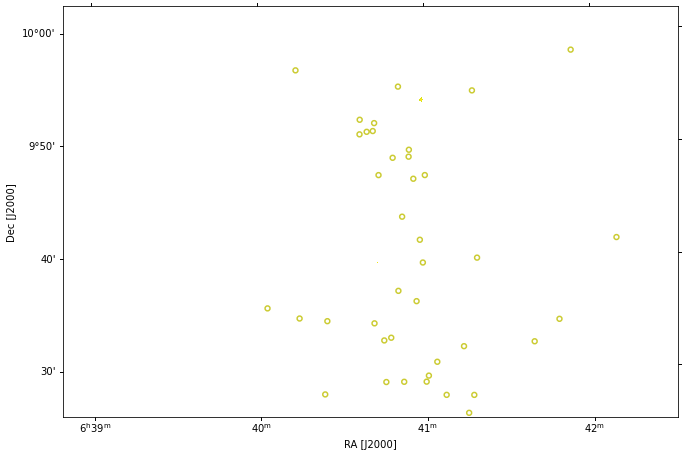

In [181]:
#Plot the apertures
%matplotlib inline

#Scale your image to something reasonble.
mn, mx = ZScaleInterval().get_limits(np.log10(image))

plt.figure(figsize = [10,7])

#Use the wcs solution to use sky coordinates when plotting. 
ax = plt.subplot(projection = w)
plt.subplots_adjust(right = 0.98, top = 0.98)

#Plot the apertures.
ax.imshow(np.log10(image), origin = 'lower', vmin = mn, vmax = mx)
aperture.plot(color='w', lw=1.5, alpha=0.8)
# simbad_aperture.plot(color = 'r', lw = 1.5, alpha =0.8)
aperture_targs.plot(color = 'y', lw = 1.5, alpha =0.8)


ax.set_xlabel('RA [J2000]')
ax.set_ylabel('Dec [J2000]')


<ipython-input-154-7e56f1a217d0>:50: RuntimeWarning: invalid value encountered in sqrt
  bkg_error = np.sqrt(bkg_values_nan)
C:\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Writing the background-only error image:  shifted_BIN2-E MasterScience_I0_bgerror.fit
Writing the total error image:  shifted_BIN2-E MasterScience_I0_error.fit


<ipython-input-154-7e56f1a217d0>:50: RuntimeWarning: invalid value encountered in sqrt
  bkg_error = np.sqrt(bkg_values_nan)
C:\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Writing the background-only error image:  shifted_BIN2-E MasterScience_I1_bgerror.fit
Writing the total error image:  shifted_BIN2-E MasterScience_I1_error.fit


<ipython-input-154-7e56f1a217d0>:50: RuntimeWarning: invalid value encountered in sqrt
  bkg_error = np.sqrt(bkg_values_nan)
C:\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Writing the background-only error image:  shifted_BIN2-E MasterScience_I2_bgerror.fit
Writing the total error image:  shifted_BIN2-E MasterScience_I2_error.fit


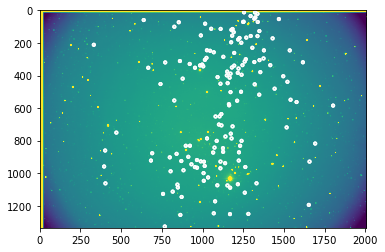

In [182]:
# os.chdir(master_dir + '/Master Blue')
# os.chdir(master_dir + '/Master Red')
# os.chdir(master_dir + '/Master Visual')
# os.chdir(master_dir + '/Master U')
os.chdir(master_dir + '/Master I')
shifted_masterlist = glob.glob('shifted_*.fit')
dat_masterlist = glob.glob('MasterScience*')

tag_removal = []
for i in np.arange(len(shifted_masterlist)):
    if 'error' in shifted_masterlist[i]:
        tag_removal.append(shifted_masterlist[i])
for i in tag_removal:
#     os.remove(master_dir + '/Master Blue/' + i)
#     os.remove(master_dir + '/Master Red/' + i)
#     os.remove(master_dir + '/Master Visual/' + i)
#     os.remove(master_dir + '/Master U/' + i)
    os.remove(master_dir + '/Master I/' + i)
shifted_masterlist = glob.glob("shifted_*.fit")

for i in shifted_masterlist:
    header = fits.getheader(i)
    error = bg_error_estimate(i)
    phot_table = measurePhotometry(i, pos_x_interest, pos_y_interest, 8, 13, 18, error)
    phot_table['bg_subtracted_star_counts'].name = 'aper_sum_bkgsub'
    phot_table['bg_sub_star_cts_err'].name = 'err'
    phot_table['SNR'] = phot_table['aper_sum_bkgsub']/phot_table['err']
    phot_table = phot_table[['id', 'xcenter', 'ycenter', 'aper_sum_bkgsub', 'err', 'SNR']]
    ascii.write(phot_table, i[14:-4] + '.dat', names = ['id', 'xcenter', 'ycenter', 'aper_sum_bkgsub', 'err', 'SNR'],overwrite=True)

In [135]:
shifted_masterlist

['shifted_BIN2-E MasterScience_I0.fit',
 'shifted_BIN2-E MasterScience_I1.fit',
 'shifted_BIN2-E MasterScience_I2.fit']

In [183]:
# os.chdir(master_dir + '/Master Blue')
# os.chdir(master_dir + '/Master Red')
# os.chdir(master_dir + '/Master Visual')
# os.chdir(master_dir + '/Master U')
os.chdir(master_dir + '/Master I')
import datetime as dt
from astropy.table import QTable
dat = glob.glob(' Master*.dat')
file = []
num = []
name = []
filter_ = []
exp = []
date = []
start = []
phot_table_file = []
x = 1
for j,i in enumerate(dat):
    hdr = fits.getheader(shifted_masterlist[j])
    #
    file.append(master_dir + '/Master I/'+shifted_masterlist[j])
    num.append(x)
    name.append('NGC_2264')
    filter_.append(hdr['FILTER'])
    exp.append(hdr['EXPTIME'])
    date.append(dt.datetime.strptime(hdr['DATE-OBS'].replace('T', ' '), '%Y-%m-%d %H:%M:%S').strftime('%Y%m%d'))
    start.append(hdr['DATE-OBS'])
    #
    phot_table_file.append(master_dir + '/Master I/'+i)
    x+=1
t = QTable([file, num, name, filter_, exp, date, start, phot_table_file],
names=['file', 'num', 'name', 'filter', 'exp', 'date', 'start', 'phot_table_file'])
ascii.write(t,'phot_master_obslog.dat', names=['file', 'num', 'name', 'filter', 'exp','date', 'start', 'phot_table_file'],overwrite=True)

In [137]:
simbad_query

,Identifier,distance_arcsecs,object,ICRS_RA,ICRS_DEC,Umag,Bmag,Vmag,Rmag,Imag,spectral_type,RA_DEC_ICRS,ra,dec
0,HD 261878,147.48,*,06 40 51.5561533288,+09 51 49.385654931,8.420,8.980,9.080,9.149,9.191,B6V,06 40 51.5561533288+09 51 49.385654931,100.214817,9.863718
1,HD 262066A,528.71,*,06 41 30.0919974816,+09 49 48.327614712,9.645,9.760,9.780,9.880,9.734,NaN,06 41 30.0919974816+09 49 48.327614712,100.375383,9.830091
2,HD 262138,746.99,*,06 41 42.0646231091,+09 47 36.089715204,9.926,9.770,9.520,NaN,9.472,A2/3,06 41 42.0646231091+09 47 36.089715204,100.425269,9.793358
3,HD 262108,555.09,*,06 41 34.6122348287,+09 51 37.920393314,10.177,10.100,10.000,NaN,9.701,A2/3,06 41 34.6122348287+09 51 37.920393314,100.394218,9.860533
4,HD 262066B,530.18,*,06 41 30.1127619517,+09 49 45.626234939,10.600,10.160,9.830,10.430,10.120,NaN,06 41 30.1127619517+09 49 45.626234939,100.375470,9.829341
5,HD 261879,879.25,*,06 40 51.8440512361,+09 39 07.474974285,10.661,10.770,10.770,NaN,10.768,A0/1,06 40 51.8440512361+09 39 07.474974285,100.216017,9.652076
6,HD 261737,893.16,*,06 40 21.4672340516,+09 41 50.569616091,10.895,10.800,10.600,10.418,10.289,A2/3,06 40 21.4672340516+09 41 50.569616091,100.089447,9.697380
7,HD 262109,838.46,*,06 41 37.4890837803,+09 43 40.057363987,11.326,11.220,10.850,NaN,10.489,F0/2,06 41 37.4890837803+09 43 40.057363987,100.406205,9.727794
8,NGC 2264 104,126.47,*,06 40 49.5382467104,+09 53 23.008493061,11.828,11.610,11.360,11.254,11.075,A5IV,06 40 49.5382467104+09 53 23.008493061,100.206409,9.889725
9,NGC 2264 60,618.93,*,06 40 32.4256314005,+10 01 52.227279892,14.075,13.480,12.450,NaN,11.081,NaN,06 40 32.4256314005+10 01 52.227279892,100.135107,10.031174


In [138]:
# location_list = ascii.read('C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/light curves/Master Blue/phot_master_obslog.dat')['phot_table_file']
# location_list = ascii.read('C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/light curves/Master Red/phot_master_obslog.dat')['phot_table_file']
# location_list = ascii.read('C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/light curves/Master Visual/phot_master_obslog.dat')['phot_table_file']
# location_list = ascii.read('C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/light curves/Master U/phot_master_obslog.dat')['phot_table_file']
location_list = ascii.read('C:/Users/Batmanlai Tsogt/Documents/College Work/Senior Year/AST341/Jupyter/light curves/Master I/phot_master_obslog.dat')['phot_table_file']

In [139]:
location_list

test_ = ascii.read(location_list[0])['aper_sum_bkgsub']
test__ = ascii.read(location_list[1])['aper_sum_bkgsub']
# test_1 = ascii.read(master_dir + '/simbad_objects.txt')['Bmag']
# test_1 = ascii.read(master_dir + '/simbad_objects.txt')['Rmag']
# test_1 = ascii.read(master_dir + '/simbad_objects.txt')['Vmag']
# test_1 = ascii.read(master_dir + '/simbad_objects.txt')['Umag']
test_1 = ascii.read(master_dir + '/simbad_objects.txt')['Imag']
exptime = 100

In [140]:
# test_mag = (-2.5)*np.log10(test_/exptime)

In [141]:
# calibrated_test = test_1-test_mag

In [142]:
# test_mag2 = (-2.5)*np.log10(test__/exptime)

In [143]:
# calibrated_test2 = test_1 - test_mag2

In [144]:
# calibrated_tests = []

In [145]:
list_counts = []
list_inst_mag = []
list_calibrated = []
for i in location_list:
    temp_ = ascii.read(i)['aper_sum_bkgsub']
    list_counts.append(temp_)
for i in list_counts:
    list_inst_mag.append((-2.5)*np.log10(i/exptime))
for i in list_inst_mag:
    tempp = test_1 - i
    list_calibrated.append(tempp)

<ipython-input-145-66971cd4e276>:8: RuntimeWarning: invalid value encountered in log10
  list_inst_mag.append((-2.5)*np.log10(i/exptime))


In [146]:
list_calibrated[1]

18.011739787801183
18.550556923979258
18.0142378079327
17.970676641422152
18.93654401296608
18.012841271139568
18.041269620165107
17.973503185144573
17.945663676276745
nan
17.83737882749822


In [147]:
list_averages = [] 
for i in list_calibrated:
    for y in np.arange(len(i)):
        if i[y] == float("-inf") or i[y] == 0 or i[y] == '':
            i[y] = float("NaN")
#     print(np.nansum(np.asarray(i)))
    avg = np.nanmean(i)
    list_averages.append(avg)

In [148]:
# averaged_b_zp = sum(list_averages)/len(list_averages)
# averaged_r_zp = sum(list_averages)/len(list_averages)
# averaged_v_zp = sum(list_averages)/len(list_averages)
# averaged_u_zp = sum(list_averages)/len(list_averages)
averaged_i_zp = sum(list_averages)/len(list_averages)

In [149]:
averaged_b_zp

20.017489859826384

In [150]:
averaged_r_zp

19.254244669808198

In [151]:
averaged_v_zp = 20.0422699132996

In [152]:
averaged_u_zp

17.206124337958865

In [153]:
averaged_i_zp

18.290529673052898